In [1]:
%matplotlib inline


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import plots, params, models, feats
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)
importlib.reload(feats)

<module 'libs.feats' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/feats.py'>

In [2]:
# Turn off interactive plotting globally (we’ll manage our own display)
import matplotlib
matplotlib.use("Agg")  # safe, headless-friendly
import matplotlib.pyplot as plt
plt.ioff()

import os
import json
import numpy as np
import pandas as pd
import datetime as dt
from pathlib import Path

from torch import nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts
from torch.cuda.amp import GradScaler, autocast

import optuna
from optuna.pruners import MedianPruner
from optuna.exceptions import TrialPruned
from optuna.importance import get_param_importances

from tqdm.auto import tqdm


In [3]:
df_feat_sel = pd.read_csv(params.feat_all_csv, index_col=0, parse_dates=True)[params.features_cols_tick + ['bid','ask'] + [params.label_col]]
    
df_feat_sel

,rsi_14,minus_di_15,eng_adx,eng_atr_div,adx_14,sma_100,vol_spike_14,macd_line_12_26_9,sma_20,bid,ask,signal
2004-01-02 13:09:00,0.00000,0.000000,0.000000,0.000279,0.625459,0.00000,0.528843,0.00000,0.00000,0.763664,0.764807,0.021536
2004-01-02 13:10:00,0.00000,0.000000,0.000000,0.000310,0.625379,0.00000,0.528775,0.00000,0.00000,0.763647,0.764790,0.023284
2004-01-02 13:11:00,0.00000,0.000000,0.000000,0.000341,0.625318,0.00000,0.528707,0.00000,0.00000,0.763631,0.764773,0.025175
2004-01-02 13:12:00,0.00000,0.000000,0.000000,0.000341,0.625263,0.00000,0.528641,0.00000,0.00000,0.763614,0.764757,0.027222
2004-01-02 13:13:00,0.00000,0.000000,0.000000,0.000341,0.625227,0.00000,0.528573,0.00000,0.00000,0.763597,0.764740,0.029436
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,0.67217,0.024691,0.023121,0.024910,0.635234,0.73661,0.541606,0.36312,0.66709,196.667400,196.962600,0.684908
2025-06-18 20:57:00,0.61669,0.024691,0.023121,0.025902,0.629672,0.58962,0.542649,0.34721,0.61512,196.527500,196.822500,0.612206
2025-06-18 20:58:00,0.61473,0.030864,0.023121,0.025499,0.628744,0.58091,0.545497,0.33627,0.61329,196.522500,196.817500,0.610468
2025-06-18 20:59:00,0.47540,0.030864,0.023121,0.031509,0.616953,0.17135,0.538547,0.29058,0.48143,196.092800,196.387200,0.477090


In [4]:
# calculate look_backs under half the interval between the day’s first and sess_start

first_time = (
    df_feat_sel.index
        .to_series()
        .groupby(df_feat_sel.index.normalize())
        .min()
        .dt.time
        .mode()[0]
)

# convert both times to minutes since midnight
fm = first_time.hour * 60 + first_time.minute
sm = params.sess_start.hour * 60 + params.sess_start.minute

# half the difference, count full 30-min slots, and build multiples
n_steps    = int(((sm - fm) / 2) // 30)      # e.g. floor(165/30) = 5
look_backs = [30 * i for i in range(1, n_steps + 1)]
look_backs


[30, 60, 90, 120]

In [5]:
# ──────────────────────────────────────────────────────────────────────────────
# Optuna objective definition
# ──────────────────────────────────────────────────────────────────────────────

# look_backs = [30, 45, 60, 75, 90] ################################

def objective(trial):
    
    hp = {
    # ── Architecture ────────────────────────────────────────────────
    "look_back"    : trial.suggest_categorical("look_back", look_backs),
    "DROPOUT_SHORT": trial.suggest_float("DROPOUT_SHORT", 0.05, 0.35),
    "DROPOUT_LONG":  trial.suggest_float("DROPOUT_LONG",  0.05, 0.35),
    "ATT_DROPOUT":   trial.suggest_float("ATT_DROPOUT",   0.05, 0.35),
    
    # ── Optimizer & Scheduler ──────────────────────────────────────
    "INITIAL_LR":    trial.suggest_float("INITIAL_LR",    1e-5, 1e-3,   log=True),
    "ETA_MIN":       trial.suggest_float("ETA_MIN",       1e-6, 1e-5,   log=True),
    "WEIGHT_DECAY":  trial.suggest_float("WEIGHT_DECAY",  1e-5, 1e-2,  log=True),
    "CLIPNORM":      trial.suggest_float("CLIPNORM",      0.1, 10),
    }

    print(f"\n▶ Trial {trial.number} starting with:\n{hp}\n")

    sess_start_pred = dt.time(*divmod((params.sess_start.hour * 60 + params.sess_start.minute) - hp["look_back"], 60))
    
    print('Build LSTM input tensors (disk-backed memmaps)...')
    X, y_sig, y_ret, raw_close, raw_bid, raw_ask, end_times = models.build_lstm_tensors(
        df            = df_feat_sel,
        sess_start    = sess_start_pred 
    )
    
    print('Split into train/val/test by calendar day...')
    (
    (X_tr,  y_sig_tr,  y_ret_tr),
    (X_val, y_sig_val, y_ret_val),
    (X_te,  y_sig_te,  y_ret_te,  raw_close_te, raw_bid_te, raw_ask_te),
    samples_per_day,
    day_id_tr, day_id_val, day_id_te
    ) = models.chronological_split(
        X, y_sig, y_ret,
        raw_close, raw_bid, raw_ask,
        end_times   = end_times,
        train_prop  = params.train_prop,
        val_prop    = params.val_prop,
        train_batch = params.hparams['TRAIN_BATCH']
    )

    print('Carve `end_times` into the same three splits...')
    n_tr  = day_id_tr .shape[0] 
    n_val = day_id_val.shape[0]
    i_tr  = n_tr
    i_val = n_tr + n_val
    
    end_times_tr  = end_times[:i_tr]
    end_times_val = end_times[i_tr:i_val]
    end_times_te  = end_times[i_val:]
    
    print('Build DataLoaders over calendar‐days...')
    train_loader, val_loader, test_loader = models.split_to_day_datasets(
        # train split:   
        X_tr,            y_sig_tr,     y_ret_tr,   end_times_tr,
        # val split:
        X_val,           y_sig_val,    y_ret_val,  end_times_val,
        # test split + raw‐prices
        X_te,            y_sig_te,     y_ret_te,   end_times_te,
        raw_close_te, raw_bid_te, raw_ask_te,
        
        sess_start_time       = sess_start_pred,
        signal_thresh         = params.best_optuna_params["buy_threshold"],
        return_thresh         = 0.01,  # flat‐zone threshold for returns (to tune)
        train_batch           = params.hparams["TRAIN_BATCH"],
        train_workers         = params.hparams["NUM_WORKERS"],
        train_prefetch_factor = params.hparams["TRAIN_PREFETCH_FACTOR"]
    )

    print('Instantiate the stateful DualMemoryLSTM...')
    model = models.DualMemoryLSTM(
        n_feats        = X.shape[-1],                          
        short_units    = params.hparams['SHORT_UNITS'],    
        long_units     = params.hparams['LONG_UNITS'],     
        dropout_short  = hp["DROPOUT_SHORT"],  
        dropout_long   = hp["DROPOUT_LONG"],   
        att_heads      = params.hparams['ATT_HEADS'],
        att_drop       = hp['ATT_DROPOUT']
    )
    model.to(params.device)  

    print('Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...')
    optimizer, plateau_sched, _ , scaler, clipnorm = \
        models.make_optimizer_and_scheduler(
            model            = model,
            initial_lr       = hp["INITIAL_LR"],
            weight_decay     = hp["WEIGHT_DECAY"],
            clipnorm         = hp["CLIPNORM"]
        )
    cosine_sched = CosineAnnealingWarmRestarts(
        optimizer, 
        T_0=params.hparams['T_0'], 
        T_mult=params.hparams['T_MULT'], 
        eta_min=hp['ETA_MIN']
    )
    
    print('Run the custom stateful training loop...')
    best_val_rmse  = models.custom_stateful_training_loop(
        model               = model,
        optimizer           = optimizer,
        cosine_sched        = cosine_sched,
        plateau_sched       = plateau_sched,
        scaler              = scaler,
        train_loader        = train_loader,
        val_loader          = val_loader,
        max_epochs          = params.hparams['MAX_EPOCHS'],
        early_stop_patience = params.hparams['EARLY_STOP_PATIENCE'],
        clipnorm            = hp["CLIPNORM"],
        device              = params.device
    )

    print('Delete variables to free memory...')
    del model, optimizer, plateau_sched, cosine_sched, scaler
    del X, y_sig, y_ret, raw_close, raw_bid, raw_ask
    del X_tr,  y_sig_tr,  y_ret_tr, X_val, y_sig_val, y_ret_val, X_te,  y_sig_te,  y_ret_te
    del raw_close_te, raw_bid_te, raw_ask_te
    del train_loader, val_loader, test_loader

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    return best_val_rmse


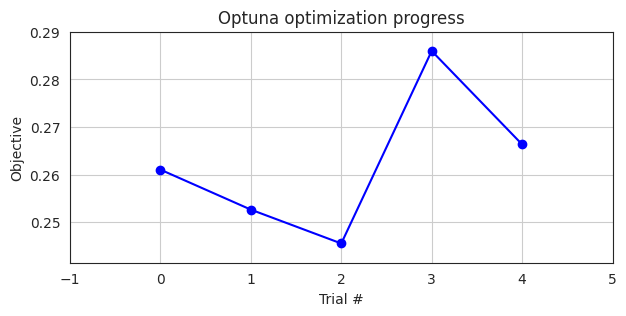

In [6]:
# build blank figure & line
fig, ax = plt.subplots(figsize=(7,3))
line, = ax.plot([], [], "bo-")
ax.set(xlabel="Trial #", ylabel="Objective",
       title="Optuna optimization progress")
ax.grid(True)

# display once and grab the handle
handle = display(fig, display_id=True)
plt.close(fig)

# ask plots.py for a callback bound to these objects
live_cb = plots.make_live_plot_callback(fig, ax, line, handle)

[I 2025-09-13 23:13:58,497] A new study created in RDB with name: no-name-6eb516c2-717f-4b3d-ab2c-e26d332c6602



▶ Trial 0 starting with:
{'look_back': 30, 'DROPOUT_SHORT': 0.16443797328765586, 'DROPOUT_LONG': 0.28669890223170574, 'ATT_DROPOUT': 0.14969892363165863, 'INITIAL_LR': 3.397632783120249e-05, 'ETA_MIN': 1.6921662099700969e-06, 'WEIGHT_DECAY': 0.00038462709802545, 'CLIPNORM': 5.069274031098703}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_lstm_tensors, using: ['rsi_14', 'minus_di_15', 'eng_adx', 'eng_atr_div', 'adx_14', 'sma_100', 'vol_spike_14', 'macd_line_12_26_9', 'sma_20']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


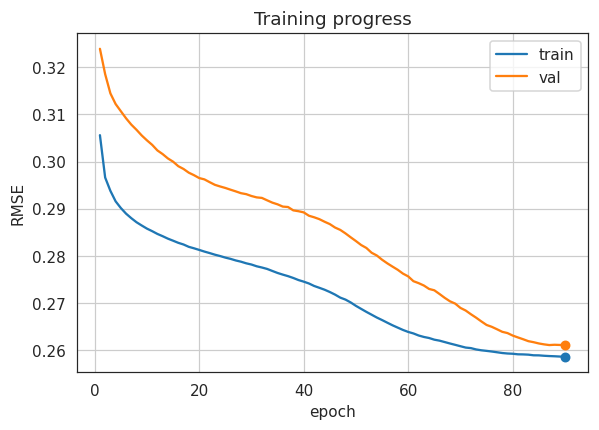

Epoch 1:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 001
TRAIN→ "R": RMSE=0.3056 MAE=0.2462 R2=-0.0969 | "B": Acc=0.3926 Prec=0.2796 Rec=0.7336 F1=0.4049 AUROC=0.4938
VALID→ "R": RMSE=0.3239 MAE=0.2140 R2=-0.2560 | "B": Acc=0.2951 Prec=0.2951 Rec=1.0000 F1=0.4557 AUROC=0.5977


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ "R": RMSE=0.2966 MAE=0.2267 R2=-0.0333 | "B": Acc=0.3736 Prec=0.2821 Rec=0.7924 F1=0.4161 AUROC=0.5016
VALID→ "R": RMSE=0.3185 MAE=0.2108 R2=-0.2147 | "B": Acc=0.2951 Prec=0.2951 Rec=1.0000 F1=0.4557 AUROC=0.5728


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ "R": RMSE=0.2938 MAE=0.2240 R2=-0.0137 | "B": Acc=0.3670 Prec=0.2820 Rec=0.8067 F1=0.4179 AUROC=0.5009
VALID→ "R": RMSE=0.3145 MAE=0.2085 R2=-0.1838 | "B": Acc=0.2951 Prec=0.2951 Rec=1.0000 F1=0.4557 AUROC=0.5502


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ "R": RMSE=0.2916 MAE=0.2231 R2=0.0016 | "B": Acc=0.3669 Prec=0.2819 Rec=0.8066 F1=0.4178 AUROC=0.4994
VALID→ "R": RMSE=0.3122 MAE=0.2072 R2=-0.1668 | "B": Acc=0.2951 Prec=0.2951 Rec=1.0000 F1=0.4557 AUROC=0.5320


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ "R": RMSE=0.2901 MAE=0.2219 R2=0.0113 | "B": Acc=0.3685 Prec=0.2816 Rec=0.8011 F1=0.4167 AUROC=0.4980
VALID→ "R": RMSE=0.3107 MAE=0.2063 R2=-0.1554 | "B": Acc=0.2951 Prec=0.2951 Rec=1.0000 F1=0.4557 AUROC=0.5184


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ "R": RMSE=0.2889 MAE=0.2208 R2=0.0194 | "B": Acc=0.3724 Prec=0.2811 Rec=0.7888 F1=0.4145 AUROC=0.4969
VALID→ "R": RMSE=0.3092 MAE=0.2055 R2=-0.1442 | "B": Acc=0.2951 Prec=0.2951 Rec=1.0000 F1=0.4557 AUROC=0.5029


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ "R": RMSE=0.2880 MAE=0.2199 R2=0.0259 | "B": Acc=0.3729 Prec=0.2810 Rec=0.7868 F1=0.4141 AUROC=0.4961
VALID→ "R": RMSE=0.3078 MAE=0.2048 R2=-0.1343 | "B": Acc=0.2951 Prec=0.2951 Rec=1.0000 F1=0.4557 AUROC=0.4893


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ "R": RMSE=0.2871 MAE=0.2190 R2=0.0317 | "B": Acc=0.3739 Prec=0.2808 Rec=0.7836 F1=0.4135 AUROC=0.4955
VALID→ "R": RMSE=0.3067 MAE=0.2042 R2=-0.1262 | "B": Acc=0.2951 Prec=0.2951 Rec=1.0000 F1=0.4557 AUROC=0.4704


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ "R": RMSE=0.2864 MAE=0.2184 R2=0.0364 | "B": Acc=0.3738 Prec=0.2802 Rec=0.7800 F1=0.4123 AUROC=0.4938
VALID→ "R": RMSE=0.3055 MAE=0.2037 R2=-0.1174 | "B": Acc=0.2951 Prec=0.2951 Rec=1.0000 F1=0.4557 AUROC=0.4512


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ "R": RMSE=0.2858 MAE=0.2178 R2=0.0409 | "B": Acc=0.3745 Prec=0.2801 Rec=0.7776 F1=0.4118 AUROC=0.4926
VALID→ "R": RMSE=0.3045 MAE=0.2032 R2=-0.1098 | "B": Acc=0.2951 Prec=0.2951 Rec=1.0000 F1=0.4557 AUROC=0.4330


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ "R": RMSE=0.2852 MAE=0.2172 R2=0.0445 | "B": Acc=0.3729 Prec=0.2799 Rec=0.7803 F1=0.4120 AUROC=0.4919
VALID→ "R": RMSE=0.3035 MAE=0.2028 R2=-0.1029 | "B": Acc=0.2951 Prec=0.2951 Rec=1.0000 F1=0.4557 AUROC=0.4178


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ "R": RMSE=0.2846 MAE=0.2168 R2=0.0484 | "B": Acc=0.3714 Prec=0.2798 Rec=0.7829 F1=0.4123 AUROC=0.4920
VALID→ "R": RMSE=0.3023 MAE=0.2023 R2=-0.0943 | "B": Acc=0.2951 Prec=0.2951 Rec=1.0000 F1=0.4557 AUROC=0.4071


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ "R": RMSE=0.2842 MAE=0.2163 R2=0.0516 | "B": Acc=0.3701 Prec=0.2800 Rec=0.7866 F1=0.4129 AUROC=0.4920
VALID→ "R": RMSE=0.3016 MAE=0.2020 R2=-0.0887 | "B": Acc=0.2951 Prec=0.2951 Rec=1.0000 F1=0.4557 AUROC=0.3941


Epoch 14:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ "R": RMSE=0.2836 MAE=0.2159 R2=0.0551 | "B": Acc=0.3676 Prec=0.2795 Rec=0.7894 F1=0.4128 AUROC=0.4907
VALID→ "R": RMSE=0.3007 MAE=0.2016 R2=-0.0821 | "B": Acc=0.2951 Prec=0.2951 Rec=1.0000 F1=0.4557 AUROC=0.3834


Epoch 15:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ "R": RMSE=0.2832 MAE=0.2155 R2=0.0580 | "B": Acc=0.3662 Prec=0.2793 Rec=0.7914 F1=0.4129 AUROC=0.4909
VALID→ "R": RMSE=0.3000 MAE=0.2013 R2=-0.0771 | "B": Acc=0.2951 Prec=0.2951 Rec=1.0000 F1=0.4557 AUROC=0.3750


Epoch 16:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 016
TRAIN→ "R": RMSE=0.2827 MAE=0.2151 R2=0.0610 | "B": Acc=0.3641 Prec=0.2791 Rec=0.7949 F1=0.4132 AUROC=0.4891
VALID→ "R": RMSE=0.2990 MAE=0.2009 R2=-0.0702 | "B": Acc=0.2951 Prec=0.2951 Rec=1.0000 F1=0.4557 AUROC=0.3689


Epoch 17:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 017
TRAIN→ "R": RMSE=0.2824 MAE=0.2149 R2=0.0633 | "B": Acc=0.3617 Prec=0.2791 Rec=0.8000 F1=0.4138 AUROC=0.4883
VALID→ "R": RMSE=0.2984 MAE=0.2006 R2=-0.0660 | "B": Acc=0.2951 Prec=0.2951 Rec=1.0000 F1=0.4557 AUROC=0.3604


Epoch 18:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 018
TRAIN→ "R": RMSE=0.2819 MAE=0.2144 R2=0.0666 | "B": Acc=0.3595 Prec=0.2791 Rec=0.8048 F1=0.4144 AUROC=0.4875
VALID→ "R": RMSE=0.2976 MAE=0.2003 R2=-0.0604 | "B": Acc=0.2951 Prec=0.2951 Rec=1.0000 F1=0.4557 AUROC=0.3555


Epoch 19:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 019
TRAIN→ "R": RMSE=0.2816 MAE=0.2142 R2=0.0687 | "B": Acc=0.3567 Prec=0.2788 Rec=0.8090 F1=0.4146 AUROC=0.4865
VALID→ "R": RMSE=0.2971 MAE=0.2000 R2=-0.0566 | "B": Acc=0.2951 Prec=0.2951 Rec=1.0000 F1=0.4557 AUROC=0.3501


Epoch 20:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 020
TRAIN→ "R": RMSE=0.2812 MAE=0.2139 R2=0.0710 | "B": Acc=0.3542 Prec=0.2788 Rec=0.8151 F1=0.4155 AUROC=0.4853
VALID→ "R": RMSE=0.2965 MAE=0.1997 R2=-0.0523 | "B": Acc=0.2951 Prec=0.2951 Rec=1.0000 F1=0.4557 AUROC=0.3484


Epoch 21:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 021
TRAIN→ "R": RMSE=0.2809 MAE=0.2135 R2=0.0733 | "B": Acc=0.3520 Prec=0.2785 Rec=0.8178 F1=0.4155 AUROC=0.4845
VALID→ "R": RMSE=0.2962 MAE=0.1996 R2=-0.0503 | "B": Acc=0.2951 Prec=0.2951 Rec=1.0000 F1=0.4557 AUROC=0.3486


Epoch 22:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 022
TRAIN→ "R": RMSE=0.2806 MAE=0.2132 R2=0.0754 | "B": Acc=0.3508 Prec=0.2785 Rec=0.8203 F1=0.4158 AUROC=0.4840
VALID→ "R": RMSE=0.2956 MAE=0.1993 R2=-0.0461 | "B": Acc=0.2951 Prec=0.2951 Rec=1.0000 F1=0.4557 AUROC=0.3505


Epoch 23:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 023
TRAIN→ "R": RMSE=0.2802 MAE=0.2128 R2=0.0776 | "B": Acc=0.3498 Prec=0.2785 Rec=0.8225 F1=0.4161 AUROC=0.4836
VALID→ "R": RMSE=0.2951 MAE=0.1990 R2=-0.0421 | "B": Acc=0.2951 Prec=0.2951 Rec=1.0000 F1=0.4557 AUROC=0.3537


Epoch 24:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 024
TRAIN→ "R": RMSE=0.2799 MAE=0.2126 R2=0.0795 | "B": Acc=0.3468 Prec=0.2787 Rec=0.8304 F1=0.4173 AUROC=0.4839
VALID→ "R": RMSE=0.2947 MAE=0.1988 R2=-0.0397 | "B": Acc=0.2951 Prec=0.2951 Rec=1.0000 F1=0.4557 AUROC=0.3593


Epoch 25:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 025
TRAIN→ "R": RMSE=0.2796 MAE=0.2123 R2=0.0817 | "B": Acc=0.3474 Prec=0.2787 Rec=0.8293 F1=0.4172 AUROC=0.4842
VALID→ "R": RMSE=0.2944 MAE=0.1986 R2=-0.0374 | "B": Acc=0.2951 Prec=0.2951 Rec=1.0000 F1=0.4557 AUROC=0.3644


Epoch 26:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 026
TRAIN→ "R": RMSE=0.2793 MAE=0.2119 R2=0.0835 | "B": Acc=0.3463 Prec=0.2788 Rec=0.8329 F1=0.4178 AUROC=0.4849
VALID→ "R": RMSE=0.2940 MAE=0.1984 R2=-0.0348 | "B": Acc=0.2951 Prec=0.2951 Rec=1.0000 F1=0.4557 AUROC=0.3703


Epoch 27:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 027
TRAIN→ "R": RMSE=0.2790 MAE=0.2116 R2=0.0857 | "B": Acc=0.3457 Prec=0.2789 Rec=0.8343 F1=0.4180 AUROC=0.4846
VALID→ "R": RMSE=0.2937 MAE=0.1982 R2=-0.0323 | "B": Acc=0.2951 Prec=0.2951 Rec=1.0000 F1=0.4557 AUROC=0.3781


Epoch 28:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 028
TRAIN→ "R": RMSE=0.2787 MAE=0.2114 R2=0.0874 | "B": Acc=0.3447 Prec=0.2789 Rec=0.8368 F1=0.4184 AUROC=0.4850
VALID→ "R": RMSE=0.2933 MAE=0.1980 R2=-0.0296 | "B": Acc=0.2951 Prec=0.2951 Rec=1.0000 F1=0.4557 AUROC=0.3844


Epoch 29:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 029
TRAIN→ "R": RMSE=0.2784 MAE=0.2112 R2=0.0897 | "B": Acc=0.3435 Prec=0.2792 Rec=0.8416 F1=0.4193 AUROC=0.4868
VALID→ "R": RMSE=0.2931 MAE=0.1978 R2=-0.0282 | "B": Acc=0.2951 Prec=0.2951 Rec=1.0000 F1=0.4557 AUROC=0.3949


Epoch 30:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 030
TRAIN→ "R": RMSE=0.2781 MAE=0.2108 R2=0.0913 | "B": Acc=0.3436 Prec=0.2794 Rec=0.8423 F1=0.4196 AUROC=0.4872
VALID→ "R": RMSE=0.2927 MAE=0.1976 R2=-0.0254 | "B": Acc=0.2951 Prec=0.2951 Rec=1.0000 F1=0.4557 AUROC=0.3998


Epoch 31:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 031
TRAIN→ "R": RMSE=0.2778 MAE=0.2106 R2=0.0938 | "B": Acc=0.3416 Prec=0.2791 Rec=0.8449 F1=0.4195 AUROC=0.4852
VALID→ "R": RMSE=0.2924 MAE=0.1973 R2=-0.0234 | "B": Acc=0.2951 Prec=0.2951 Rec=1.0000 F1=0.4557 AUROC=0.4050


Epoch 32:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 032
TRAIN→ "R": RMSE=0.2775 MAE=0.2103 R2=0.0955 | "B": Acc=0.3423 Prec=0.2793 Rec=0.8452 F1=0.4199 AUROC=0.4867
VALID→ "R": RMSE=0.2923 MAE=0.1972 R2=-0.0226 | "B": Acc=0.2951 Prec=0.2951 Rec=1.0000 F1=0.4557 AUROC=0.4111


Epoch 33:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 033
TRAIN→ "R": RMSE=0.2772 MAE=0.2100 R2=0.0974 | "B": Acc=0.3416 Prec=0.2793 Rec=0.8466 F1=0.4201 AUROC=0.4865
VALID→ "R": RMSE=0.2918 MAE=0.1969 R2=-0.0190 | "B": Acc=0.2951 Prec=0.2951 Rec=1.0000 F1=0.4557 AUROC=0.4159


Epoch 34:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 034
TRAIN→ "R": RMSE=0.2768 MAE=0.2097 R2=0.1002 | "B": Acc=0.3399 Prec=0.2792 Rec=0.8493 F1=0.4202 AUROC=0.4857
VALID→ "R": RMSE=0.2913 MAE=0.1966 R2=-0.0156 | "B": Acc=0.2951 Prec=0.2951 Rec=1.0000 F1=0.4557 AUROC=0.4183


Epoch 35:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 035
TRAIN→ "R": RMSE=0.2763 MAE=0.2093 R2=0.1030 | "B": Acc=0.3387 Prec=0.2788 Rec=0.8497 F1=0.4199 AUROC=0.4848
VALID→ "R": RMSE=0.2909 MAE=0.1964 R2=-0.0131 | "B": Acc=0.2951 Prec=0.2951 Rec=1.0000 F1=0.4557 AUROC=0.4201


Epoch 36:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 036
TRAIN→ "R": RMSE=0.2760 MAE=0.2091 R2=0.1053 | "B": Acc=0.3385 Prec=0.2793 Rec=0.8532 F1=0.4208 AUROC=0.4853
VALID→ "R": RMSE=0.2904 MAE=0.1961 R2=-0.0098 | "B": Acc=0.2951 Prec=0.2951 Rec=1.0000 F1=0.4557 AUROC=0.4203


Epoch 37:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 037
TRAIN→ "R": RMSE=0.2757 MAE=0.2088 R2=0.1074 | "B": Acc=0.3370 Prec=0.2788 Rec=0.8531 F1=0.4202 AUROC=0.4835
VALID→ "R": RMSE=0.2903 MAE=0.1959 R2=-0.0091 | "B": Acc=0.2951 Prec=0.2951 Rec=1.0000 F1=0.4557 AUROC=0.4228


Epoch 38:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 038
TRAIN→ "R": RMSE=0.2753 MAE=0.2085 R2=0.1099 | "B": Acc=0.3369 Prec=0.2788 Rec=0.8534 F1=0.4203 AUROC=0.4843
VALID→ "R": RMSE=0.2896 MAE=0.1956 R2=-0.0042 | "B": Acc=0.2951 Prec=0.2951 Rec=1.0000 F1=0.4557 AUROC=0.4241


Epoch 39:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 039
TRAIN→ "R": RMSE=0.2748 MAE=0.2083 R2=0.1127 | "B": Acc=0.3351 Prec=0.2787 Rec=0.8566 F1=0.4205 AUROC=0.4830
VALID→ "R": RMSE=0.2895 MAE=0.1954 R2=-0.0030 | "B": Acc=0.2951 Prec=0.2951 Rec=1.0000 F1=0.4557 AUROC=0.4256


Epoch 40:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 040
TRAIN→ "R": RMSE=0.2745 MAE=0.2079 R2=0.1149 | "B": Acc=0.3346 Prec=0.2786 Rec=0.8575 F1=0.4206 AUROC=0.4827
VALID→ "R": RMSE=0.2892 MAE=0.1952 R2=-0.0012 | "B": Acc=0.2951 Prec=0.2951 Rec=1.0000 F1=0.4557 AUROC=0.4265


Epoch 41:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 041
TRAIN→ "R": RMSE=0.2741 MAE=0.2076 R2=0.1174 | "B": Acc=0.3337 Prec=0.2784 Rec=0.8583 F1=0.4205 AUROC=0.4818
VALID→ "R": RMSE=0.2885 MAE=0.1948 R2=0.0037 | "B": Acc=0.2951 Prec=0.2951 Rec=0.9999 F1=0.4557 AUROC=0.4264


Epoch 42:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 042
TRAIN→ "R": RMSE=0.2736 MAE=0.2074 R2=0.1208 | "B": Acc=0.3323 Prec=0.2782 Rec=0.8598 F1=0.4204 AUROC=0.4812
VALID→ "R": RMSE=0.2882 MAE=0.1946 R2=0.0060 | "B": Acc=0.2951 Prec=0.2951 Rec=0.9999 F1=0.4557 AUROC=0.4228


Epoch 43:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 043
TRAIN→ "R": RMSE=0.2732 MAE=0.2070 R2=0.1233 | "B": Acc=0.3318 Prec=0.2781 Rec=0.8602 F1=0.4204 AUROC=0.4797
VALID→ "R": RMSE=0.2878 MAE=0.1943 R2=0.0087 | "B": Acc=0.2951 Prec=0.2951 Rec=0.9998 F1=0.4557 AUROC=0.4228


Epoch 44:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 044
TRAIN→ "R": RMSE=0.2728 MAE=0.2067 R2=0.1259 | "B": Acc=0.3303 Prec=0.2781 Rec=0.8632 F1=0.4206 AUROC=0.4802
VALID→ "R": RMSE=0.2872 MAE=0.1940 R2=0.0125 | "B": Acc=0.2950 Prec=0.2950 Rec=0.9996 F1=0.4556 AUROC=0.4249


Epoch 45:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 045
TRAIN→ "R": RMSE=0.2723 MAE=0.2065 R2=0.1291 | "B": Acc=0.3298 Prec=0.2779 Rec=0.8632 F1=0.4204 AUROC=0.4793
VALID→ "R": RMSE=0.2867 MAE=0.1936 R2=0.0159 | "B": Acc=0.2950 Prec=0.2950 Rec=0.9995 F1=0.4556 AUROC=0.4233


Epoch 46:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 046
TRAIN→ "R": RMSE=0.2718 MAE=0.2060 R2=0.1326 | "B": Acc=0.3292 Prec=0.2781 Rec=0.8658 F1=0.4210 AUROC=0.4790
VALID→ "R": RMSE=0.2860 MAE=0.1932 R2=0.0209 | "B": Acc=0.2950 Prec=0.2950 Rec=0.9994 F1=0.4555 AUROC=0.4206


Epoch 47:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 047
TRAIN→ "R": RMSE=0.2711 MAE=0.2057 R2=0.1366 | "B": Acc=0.3278 Prec=0.2779 Rec=0.8677 F1=0.4210 AUROC=0.4780
VALID→ "R": RMSE=0.2855 MAE=0.1929 R2=0.0243 | "B": Acc=0.2949 Prec=0.2949 Rec=0.9991 F1=0.4554 AUROC=0.4166


Epoch 48:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 048
TRAIN→ "R": RMSE=0.2707 MAE=0.2054 R2=0.1393 | "B": Acc=0.3272 Prec=0.2779 Rec=0.8689 F1=0.4211 AUROC=0.4771
VALID→ "R": RMSE=0.2847 MAE=0.1925 R2=0.0294 | "B": Acc=0.2948 Prec=0.2949 Rec=0.9989 F1=0.4553 AUROC=0.4139


Epoch 49:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 049
TRAIN→ "R": RMSE=0.2701 MAE=0.2050 R2=0.1432 | "B": Acc=0.3266 Prec=0.2778 Rec=0.8693 F1=0.4210 AUROC=0.4762
VALID→ "R": RMSE=0.2839 MAE=0.1920 R2=0.0351 | "B": Acc=0.2948 Prec=0.2949 Rec=0.9987 F1=0.4553 AUROC=0.4146


Epoch 50:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 050
TRAIN→ "R": RMSE=0.2694 MAE=0.2046 R2=0.1478 | "B": Acc=0.3255 Prec=0.2775 Rec=0.8699 F1=0.4208 AUROC=0.4753
VALID→ "R": RMSE=0.2831 MAE=0.1916 R2=0.0405 | "B": Acc=0.2947 Prec=0.2948 Rec=0.9984 F1=0.4552 AUROC=0.4104


Epoch 51:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 051
TRAIN→ "R": RMSE=0.2687 MAE=0.2041 R2=0.1518 | "B": Acc=0.3255 Prec=0.2778 Rec=0.8719 F1=0.4213 AUROC=0.4752
VALID→ "R": RMSE=0.2823 MAE=0.1911 R2=0.0462 | "B": Acc=0.2947 Prec=0.2948 Rec=0.9983 F1=0.4551 AUROC=0.4071


Epoch 52:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 052
TRAIN→ "R": RMSE=0.2681 MAE=0.2038 R2=0.1558 | "B": Acc=0.3237 Prec=0.2776 Rec=0.8744 F1=0.4214 AUROC=0.4736
VALID→ "R": RMSE=0.2817 MAE=0.1907 R2=0.0504 | "B": Acc=0.2946 Prec=0.2947 Rec=0.9980 F1=0.4550 AUROC=0.4049


Epoch 53:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 053
TRAIN→ "R": RMSE=0.2675 MAE=0.2033 R2=0.1596 | "B": Acc=0.3237 Prec=0.2773 Rec=0.8729 F1=0.4209 AUROC=0.4729
VALID→ "R": RMSE=0.2806 MAE=0.1902 R2=0.0572 | "B": Acc=0.2945 Prec=0.2947 Rec=0.9979 F1=0.4550 AUROC=0.4023


Epoch 54:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 054
TRAIN→ "R": RMSE=0.2669 MAE=0.2029 R2=0.1634 | "B": Acc=0.3220 Prec=0.2774 Rec=0.8769 F1=0.4215 AUROC=0.4724
VALID→ "R": RMSE=0.2801 MAE=0.1899 R2=0.0611 | "B": Acc=0.2945 Prec=0.2947 Rec=0.9977 F1=0.4549 AUROC=0.4023


Epoch 55:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 055
TRAIN→ "R": RMSE=0.2664 MAE=0.2025 R2=0.1667 | "B": Acc=0.3216 Prec=0.2772 Rec=0.8766 F1=0.4212 AUROC=0.4717
VALID→ "R": RMSE=0.2792 MAE=0.1895 R2=0.0671 | "B": Acc=0.2944 Prec=0.2946 Rec=0.9973 F1=0.4548 AUROC=0.3999


Epoch 56:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 056
TRAIN→ "R": RMSE=0.2658 MAE=0.2021 R2=0.1702 | "B": Acc=0.3209 Prec=0.2770 Rec=0.8767 F1=0.4210 AUROC=0.4707
VALID→ "R": RMSE=0.2784 MAE=0.1890 R2=0.0722 | "B": Acc=0.2944 Prec=0.2946 Rec=0.9973 F1=0.4548 AUROC=0.3988


Epoch 57:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 057
TRAIN→ "R": RMSE=0.2652 MAE=0.2018 R2=0.1736 | "B": Acc=0.3203 Prec=0.2771 Rec=0.8786 F1=0.4213 AUROC=0.4710
VALID→ "R": RMSE=0.2777 MAE=0.1887 R2=0.0768 | "B": Acc=0.2943 Prec=0.2945 Rec=0.9970 F1=0.4547 AUROC=0.3968


Epoch 58:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 058
TRAIN→ "R": RMSE=0.2647 MAE=0.2014 R2=0.1767 | "B": Acc=0.3198 Prec=0.2768 Rec=0.8774 F1=0.4208 AUROC=0.4698
VALID→ "R": RMSE=0.2770 MAE=0.1883 R2=0.0813 | "B": Acc=0.2942 Prec=0.2945 Rec=0.9968 F1=0.4546 AUROC=0.3946


Epoch 59:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 059
TRAIN→ "R": RMSE=0.2643 MAE=0.2010 R2=0.1798 | "B": Acc=0.3195 Prec=0.2767 Rec=0.8777 F1=0.4208 AUROC=0.4685
VALID→ "R": RMSE=0.2762 MAE=0.1879 R2=0.0867 | "B": Acc=0.2941 Prec=0.2944 Rec=0.9965 F1=0.4545 AUROC=0.3925


Epoch 60:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 060
TRAIN→ "R": RMSE=0.2638 MAE=0.2008 R2=0.1824 | "B": Acc=0.3202 Prec=0.2768 Rec=0.8766 F1=0.4207 AUROC=0.4682
VALID→ "R": RMSE=0.2756 MAE=0.1876 R2=0.0906 | "B": Acc=0.2941 Prec=0.2943 Rec=0.9961 F1=0.4544 AUROC=0.3919


Epoch 61:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 061
TRAIN→ "R": RMSE=0.2635 MAE=0.2005 R2=0.1844 | "B": Acc=0.3202 Prec=0.2767 Rec=0.8757 F1=0.4205 AUROC=0.4687
VALID→ "R": RMSE=0.2746 MAE=0.1873 R2=0.0973 | "B": Acc=0.2940 Prec=0.2943 Rec=0.9959 F1=0.4543 AUROC=0.3912


Epoch 62:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 062
TRAIN→ "R": RMSE=0.2631 MAE=0.2003 R2=0.1871 | "B": Acc=0.3196 Prec=0.2766 Rec=0.8766 F1=0.4205 AUROC=0.4686
VALID→ "R": RMSE=0.2742 MAE=0.1870 R2=0.1000 | "B": Acc=0.2940 Prec=0.2943 Rec=0.9959 F1=0.4543 AUROC=0.3928


Epoch 63:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 063
TRAIN→ "R": RMSE=0.2628 MAE=0.2000 R2=0.1890 | "B": Acc=0.3193 Prec=0.2767 Rec=0.8777 F1=0.4207 AUROC=0.4682
VALID→ "R": RMSE=0.2737 MAE=0.1868 R2=0.1033 | "B": Acc=0.2939 Prec=0.2942 Rec=0.9955 F1=0.4542 AUROC=0.3924


Epoch 64:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 064
TRAIN→ "R": RMSE=0.2625 MAE=0.1998 R2=0.1904 | "B": Acc=0.3197 Prec=0.2766 Rec=0.8765 F1=0.4205 AUROC=0.4684
VALID→ "R": RMSE=0.2730 MAE=0.1865 R2=0.1081 | "B": Acc=0.2938 Prec=0.2942 Rec=0.9952 F1=0.4541 AUROC=0.3924


Epoch 65:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 065
TRAIN→ "R": RMSE=0.2622 MAE=0.1996 R2=0.1925 | "B": Acc=0.3195 Prec=0.2768 Rec=0.8783 F1=0.4209 AUROC=0.4684
VALID→ "R": RMSE=0.2727 MAE=0.1863 R2=0.1100 | "B": Acc=0.2939 Prec=0.2942 Rec=0.9954 F1=0.4542 AUROC=0.3941


Epoch 66:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 066
TRAIN→ "R": RMSE=0.2620 MAE=0.1993 R2=0.1938 | "B": Acc=0.3186 Prec=0.2765 Rec=0.8782 F1=0.4206 AUROC=0.4674
VALID→ "R": RMSE=0.2719 MAE=0.1860 R2=0.1151 | "B": Acc=0.2939 Prec=0.2942 Rec=0.9955 F1=0.4542 AUROC=0.3940


Epoch 67:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 067
TRAIN→ "R": RMSE=0.2617 MAE=0.1991 R2=0.1957 | "B": Acc=0.3190 Prec=0.2769 Rec=0.8798 F1=0.4212 AUROC=0.4683
VALID→ "R": RMSE=0.2711 MAE=0.1858 R2=0.1204 | "B": Acc=0.2937 Prec=0.2941 Rec=0.9949 F1=0.4540 AUROC=0.3923


Epoch 68:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 068
TRAIN→ "R": RMSE=0.2614 MAE=0.1988 R2=0.1975 | "B": Acc=0.3190 Prec=0.2766 Rec=0.8779 F1=0.4206 AUROC=0.4679
VALID→ "R": RMSE=0.2703 MAE=0.1856 R2=0.1252 | "B": Acc=0.2938 Prec=0.2941 Rec=0.9950 F1=0.4540 AUROC=0.3942


Epoch 69:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 069
TRAIN→ "R": RMSE=0.2611 MAE=0.1986 R2=0.1993 | "B": Acc=0.3185 Prec=0.2767 Rec=0.8794 F1=0.4209 AUROC=0.4683
VALID→ "R": RMSE=0.2698 MAE=0.1854 R2=0.1283 | "B": Acc=0.2937 Prec=0.2941 Rec=0.9949 F1=0.4540 AUROC=0.3941


Epoch 70:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 070
TRAIN→ "R": RMSE=0.2608 MAE=0.1982 R2=0.2011 | "B": Acc=0.3184 Prec=0.2766 Rec=0.8794 F1=0.4209 AUROC=0.4681
VALID→ "R": RMSE=0.2689 MAE=0.1852 R2=0.1342 | "B": Acc=0.2937 Prec=0.2941 Rec=0.9948 F1=0.4539 AUROC=0.3944


Epoch 71:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 071
TRAIN→ "R": RMSE=0.2605 MAE=0.1982 R2=0.2028 | "B": Acc=0.3189 Prec=0.2770 Rec=0.8808 F1=0.4215 AUROC=0.4693
VALID→ "R": RMSE=0.2684 MAE=0.1850 R2=0.1378 | "B": Acc=0.2937 Prec=0.2940 Rec=0.9945 F1=0.4539 AUROC=0.3948


Epoch 72:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 072
TRAIN→ "R": RMSE=0.2604 MAE=0.1981 R2=0.2035 | "B": Acc=0.3189 Prec=0.2769 Rec=0.8806 F1=0.4214 AUROC=0.4688
VALID→ "R": RMSE=0.2676 MAE=0.1849 R2=0.1428 | "B": Acc=0.2936 Prec=0.2940 Rec=0.9944 F1=0.4538 AUROC=0.3951


Epoch 73:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 073
TRAIN→ "R": RMSE=0.2601 MAE=0.1979 R2=0.2053 | "B": Acc=0.3188 Prec=0.2769 Rec=0.8805 F1=0.4213 AUROC=0.4683
VALID→ "R": RMSE=0.2669 MAE=0.1848 R2=0.1475 | "B": Acc=0.2935 Prec=0.2939 Rec=0.9940 F1=0.4537 AUROC=0.3946


Epoch 74:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 074
TRAIN→ "R": RMSE=0.2599 MAE=0.1979 R2=0.2064 | "B": Acc=0.3192 Prec=0.2769 Rec=0.8792 F1=0.4211 AUROC=0.4693
VALID→ "R": RMSE=0.2661 MAE=0.1846 R2=0.1526 | "B": Acc=0.2934 Prec=0.2938 Rec=0.9936 F1=0.4535 AUROC=0.3931


Epoch 75:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 075
TRAIN→ "R": RMSE=0.2598 MAE=0.1977 R2=0.2071 | "B": Acc=0.3194 Prec=0.2769 Rec=0.8793 F1=0.4212 AUROC=0.4691
VALID→ "R": RMSE=0.2653 MAE=0.1845 R2=0.1573 | "B": Acc=0.2934 Prec=0.2938 Rec=0.9936 F1=0.4535 AUROC=0.3951


Epoch 76:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 076
TRAIN→ "R": RMSE=0.2597 MAE=0.1977 R2=0.2079 | "B": Acc=0.3190 Prec=0.2770 Rec=0.8808 F1=0.4215 AUROC=0.4694
VALID→ "R": RMSE=0.2649 MAE=0.1845 R2=0.1599 | "B": Acc=0.2934 Prec=0.2938 Rec=0.9936 F1=0.4535 AUROC=0.3966


Epoch 77:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 077
TRAIN→ "R": RMSE=0.2595 MAE=0.1975 R2=0.2089 | "B": Acc=0.3196 Prec=0.2772 Rec=0.8805 F1=0.4216 AUROC=0.4701
VALID→ "R": RMSE=0.2644 MAE=0.1844 R2=0.1631 | "B": Acc=0.2934 Prec=0.2938 Rec=0.9934 F1=0.4535 AUROC=0.3980


Epoch 78:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 078
TRAIN→ "R": RMSE=0.2594 MAE=0.1974 R2=0.2099 | "B": Acc=0.3195 Prec=0.2773 Rec=0.8815 F1=0.4218 AUROC=0.4698
VALID→ "R": RMSE=0.2639 MAE=0.1844 R2=0.1666 | "B": Acc=0.2934 Prec=0.2938 Rec=0.9934 F1=0.4535 AUROC=0.3997


Epoch 79:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 079
TRAIN→ "R": RMSE=0.2593 MAE=0.1975 R2=0.2105 | "B": Acc=0.3193 Prec=0.2772 Rec=0.8812 F1=0.4217 AUROC=0.4706
VALID→ "R": RMSE=0.2636 MAE=0.1844 R2=0.1682 | "B": Acc=0.2933 Prec=0.2937 Rec=0.9931 F1=0.4534 AUROC=0.3996


Epoch 80:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 080
TRAIN→ "R": RMSE=0.2592 MAE=0.1974 R2=0.2108 | "B": Acc=0.3191 Prec=0.2770 Rec=0.8808 F1=0.4215 AUROC=0.4703
VALID→ "R": RMSE=0.2631 MAE=0.1843 R2=0.1716 | "B": Acc=0.2933 Prec=0.2937 Rec=0.9931 F1=0.4534 AUROC=0.4008


Epoch 81:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 081
TRAIN→ "R": RMSE=0.2591 MAE=0.1974 R2=0.2115 | "B": Acc=0.3195 Prec=0.2771 Rec=0.8806 F1=0.4216 AUROC=0.4706
VALID→ "R": RMSE=0.2627 MAE=0.1843 R2=0.1741 | "B": Acc=0.2933 Prec=0.2937 Rec=0.9930 F1=0.4533 AUROC=0.4005


Epoch 82:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 082
TRAIN→ "R": RMSE=0.2591 MAE=0.1975 R2=0.2117 | "B": Acc=0.3195 Prec=0.2772 Rec=0.8810 F1=0.4217 AUROC=0.4696
VALID→ "R": RMSE=0.2623 MAE=0.1843 R2=0.1765 | "B": Acc=0.2932 Prec=0.2937 Rec=0.9928 F1=0.4533 AUROC=0.4007


Epoch 83:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 083
TRAIN→ "R": RMSE=0.2590 MAE=0.1974 R2=0.2120 | "B": Acc=0.3195 Prec=0.2770 Rec=0.8793 F1=0.4212 AUROC=0.4699
VALID→ "R": RMSE=0.2619 MAE=0.1843 R2=0.1791 | "B": Acc=0.2932 Prec=0.2937 Rec=0.9927 F1=0.4532 AUROC=0.3999


Epoch 84:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 084
TRAIN→ "R": RMSE=0.2589 MAE=0.1975 R2=0.2128 | "B": Acc=0.3197 Prec=0.2771 Rec=0.8802 F1=0.4216 AUROC=0.4694
VALID→ "R": RMSE=0.2617 MAE=0.1843 R2=0.1804 | "B": Acc=0.2931 Prec=0.2936 Rec=0.9925 F1=0.4532 AUROC=0.4001


Epoch 85:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 085
TRAIN→ "R": RMSE=0.2589 MAE=0.1974 R2=0.2129 | "B": Acc=0.3196 Prec=0.2771 Rec=0.8800 F1=0.4215 AUROC=0.4711
VALID→ "R": RMSE=0.2614 MAE=0.1843 R2=0.1821 | "B": Acc=0.2931 Prec=0.2936 Rec=0.9924 F1=0.4531 AUROC=0.4002


Epoch 86:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 086
TRAIN→ "R": RMSE=0.2588 MAE=0.1973 R2=0.2134 | "B": Acc=0.3199 Prec=0.2770 Rec=0.8788 F1=0.4212 AUROC=0.4700
VALID→ "R": RMSE=0.2612 MAE=0.1843 R2=0.1833 | "B": Acc=0.2931 Prec=0.2936 Rec=0.9923 F1=0.4531 AUROC=0.3999


Epoch 87:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 087
TRAIN→ "R": RMSE=0.2587 MAE=0.1973 R2=0.2138 | "B": Acc=0.3205 Prec=0.2772 Rec=0.8786 F1=0.4214 AUROC=0.4700
VALID→ "R": RMSE=0.2610 MAE=0.1843 R2=0.1842 | "B": Acc=0.2930 Prec=0.2935 Rec=0.9921 F1=0.4530 AUROC=0.3997


Epoch 88:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 088
TRAIN→ "R": RMSE=0.2587 MAE=0.1972 R2=0.2141 | "B": Acc=0.3201 Prec=0.2770 Rec=0.8783 F1=0.4212 AUROC=0.4702
VALID→ "R": RMSE=0.2611 MAE=0.1843 R2=0.1838 | "B": Acc=0.2930 Prec=0.2936 Rec=0.9922 F1=0.4531 AUROC=0.4010


Epoch 89:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 089
TRAIN→ "R": RMSE=0.2586 MAE=0.1972 R2=0.2144 | "B": Acc=0.3203 Prec=0.2772 Rec=0.8792 F1=0.4215 AUROC=0.4703
VALID→ "R": RMSE=0.2611 MAE=0.1843 R2=0.1841 | "B": Acc=0.2930 Prec=0.2935 Rec=0.9921 F1=0.4530 AUROC=0.4017


Epoch 90:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 090
TRAIN→ "R": RMSE=0.2586 MAE=0.1971 R2=0.2148 | "B": Acc=0.3204 Prec=0.2773 Rec=0.8798 F1=0.4217 AUROC=0.4711
VALID→ "R": RMSE=0.2611 MAE=0.1842 R2=0.1839 | "B": Acc=0.2930 Prec=0.2935 Rec=0.9919 F1=0.4530 AUROC=0.4023
Delete variables to free memory...


[I 2025-09-14 00:20:33,178] Trial 0 finished with value: 0.2610495984554291 and parameters: {'look_back': 30, 'DROPOUT_SHORT': 0.16443797328765586, 'DROPOUT_LONG': 0.28669890223170574, 'ATT_DROPOUT': 0.14969892363165863, 'INITIAL_LR': 3.397632783120249e-05, 'ETA_MIN': 1.6921662099700969e-06, 'WEIGHT_DECAY': 0.00038462709802545, 'CLIPNORM': 5.069274031098703}. Best is trial 0 with value: 0.2610495984554291.



▶ Trial 1 starting with:
{'look_back': 30, 'DROPOUT_SHORT': 0.24806879039019447, 'DROPOUT_LONG': 0.26499339776072267, 'ATT_DROPOUT': 0.0734486699250516, 'INITIAL_LR': 0.0002970247060606314, 'ETA_MIN': 2.2479873660930364e-06, 'WEIGHT_DECAY': 0.0015236987134836686, 'CLIPNORM': 4.705373349051482}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_lstm_tensors, using: ['rsi_14', 'minus_di_15', 'eng_adx', 'eng_atr_div', 'adx_14', 'sma_100', 'vol_spike_14', 'macd_line_12_26_9', 'sma_20']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


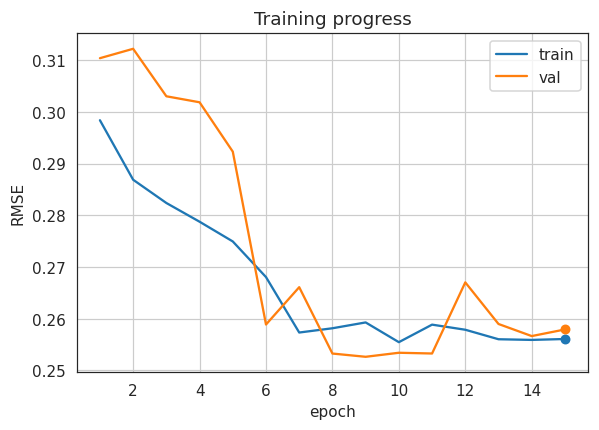

Epoch 1:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 001
TRAIN→ "R": RMSE=0.2984 MAE=0.2370 R2=-0.0459 | "B": Acc=0.4781 Prec=0.2925 Rec=0.6015 F1=0.3936 AUROC=0.5222
VALID→ "R": RMSE=0.3104 MAE=0.2080 R2=-0.1534 | "B": Acc=0.5869 Prec=0.3821 Rec=0.6474 F1=0.4805 AUROC=0.6500


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ "R": RMSE=0.2869 MAE=0.2254 R2=0.0332 | "B": Acc=0.5387 Prec=0.3207 Rec=0.5705 F1=0.4105 AUROC=0.5670
VALID→ "R": RMSE=0.3122 MAE=0.2066 R2=-0.1670 | "B": Acc=0.7239 Prec=0.5784 Rec=0.2382 F1=0.3375 AUROC=0.6592


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ "R": RMSE=0.2824 MAE=0.2186 R2=0.0633 | "B": Acc=0.6094 Prec=0.3476 Rec=0.4413 F1=0.3889 AUROC=0.5856
VALID→ "R": RMSE=0.3030 MAE=0.2021 R2=-0.0993 | "B": Acc=0.7252 Prec=0.5721 Rec=0.2728 F1=0.3694 AUROC=0.6720


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ "R": RMSE=0.2788 MAE=0.2152 R2=0.0872 | "B": Acc=0.6346 Prec=0.3703 Rec=0.4245 F1=0.3956 AUROC=0.6039
VALID→ "R": RMSE=0.3019 MAE=0.2003 R2=-0.0909 | "B": Acc=0.7312 Prec=0.6118 Rec=0.2441 F1=0.3490 AUROC=0.6908


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ "R": RMSE=0.2750 MAE=0.2132 R2=0.1120 | "B": Acc=0.6520 Prec=0.3915 Rec=0.4252 F1=0.4076 AUROC=0.6232
VALID→ "R": RMSE=0.2923 MAE=0.1946 R2=-0.0230 | "B": Acc=0.7374 Prec=0.6306 Rec=0.2663 F1=0.3745 AUROC=0.7177


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ "R": RMSE=0.2681 MAE=0.2073 R2=0.1560 | "B": Acc=0.6720 Prec=0.4206 Rec=0.4358 F1=0.4281 AUROC=0.6481
VALID→ "R": RMSE=0.2589 MAE=0.1897 R2=0.1977 | "B": Acc=0.7167 Prec=0.5193 Rec=0.5388 F1=0.5289 AUROC=0.7368


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ "R": RMSE=0.2573 MAE=0.1963 R2=0.2222 | "B": Acc=0.6959 Prec=0.4609 Rec=0.4702 F1=0.4655 AUROC=0.6861
VALID→ "R": RMSE=0.2661 MAE=0.2154 R2=0.1523 | "B": Acc=0.6358 Prec=0.4336 Rec=0.7645 F1=0.5533 AUROC=0.7455


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ "R": RMSE=0.2582 MAE=0.1988 R2=0.2172 | "B": Acc=0.6913 Prec=0.4567 Rec=0.5077 F1=0.4809 AUROC=0.6927
VALID→ "R": RMSE=0.2533 MAE=0.1938 R2=0.2321 | "B": Acc=0.6991 Prec=0.4923 Rec=0.6322 F1=0.5535 AUROC=0.7467


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ "R": RMSE=0.2593 MAE=0.2004 R2=0.2103 | "B": Acc=0.6932 Prec=0.4581 Rec=0.4884 F1=0.4728 AUROC=0.6892
VALID→ "R": RMSE=0.2526 MAE=0.1899 R2=0.2359 | "B": Acc=0.7170 Prec=0.5182 Rec=0.5821 F1=0.5483 AUROC=0.7489


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ "R": RMSE=0.2555 MAE=0.1957 R2=0.2334 | "B": Acc=0.7082 Prec=0.4814 Rec=0.4685 F1=0.4748 AUROC=0.7013
VALID→ "R": RMSE=0.2534 MAE=0.1980 R2=0.2312 | "B": Acc=0.6999 Prec=0.4934 Rec=0.6390 F1=0.5569 AUROC=0.7487


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ "R": RMSE=0.2589 MAE=0.1995 R2=0.2129 | "B": Acc=0.7123 Prec=0.4876 Rec=0.4232 F1=0.4531 AUROC=0.6918
VALID→ "R": RMSE=0.2533 MAE=0.1920 R2=0.2320 | "B": Acc=0.7262 Prec=0.5354 Rec=0.5461 F1=0.5407 AUROC=0.7499


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ "R": RMSE=0.2579 MAE=0.2005 R2=0.2189 | "B": Acc=0.7135 Prec=0.4902 Rec=0.4313 F1=0.4589 AUROC=0.6945
VALID→ "R": RMSE=0.2670 MAE=0.1828 R2=0.1463 | "B": Acc=0.7468 Prec=0.6658 Rec=0.2848 F1=0.3990 AUROC=0.7505


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ "R": RMSE=0.2560 MAE=0.1966 R2=0.2300 | "B": Acc=0.7212 Prec=0.5062 Rec=0.4153 F1=0.4563 AUROC=0.7007
VALID→ "R": RMSE=0.2590 MAE=0.1818 R2=0.1970 | "B": Acc=0.7478 Prec=0.6322 Rec=0.3473 F1=0.4484 AUROC=0.7509


Epoch 14:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ "R": RMSE=0.2559 MAE=0.1966 R2=0.2308 | "B": Acc=0.7282 Prec=0.5238 Rec=0.3830 F1=0.4425 AUROC=0.7008
VALID→ "R": RMSE=0.2567 MAE=0.1824 R2=0.2115 | "B": Acc=0.7478 Prec=0.6247 Rec=0.3642 F1=0.4601 AUROC=0.7508


Epoch 15:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ "R": RMSE=0.2561 MAE=0.1982 R2=0.2297 | "B": Acc=0.7273 Prec=0.5210 Rec=0.3927 F1=0.4479 AUROC=0.7012
VALID→ "R": RMSE=0.2579 MAE=0.1819 R2=0.2036 | "B": Acc=0.7480 Prec=0.6407 Rec=0.3326 F1=0.4379 AUROC=0.7507
Early stopping at epoch 15
Delete variables to free memory...


[I 2025-09-14 00:32:20,164] Trial 1 finished with value: 0.25264817476272583 and parameters: {'look_back': 30, 'DROPOUT_SHORT': 0.24806879039019447, 'DROPOUT_LONG': 0.26499339776072267, 'ATT_DROPOUT': 0.0734486699250516, 'INITIAL_LR': 0.0002970247060606314, 'ETA_MIN': 2.2479873660930364e-06, 'WEIGHT_DECAY': 0.0015236987134836686, 'CLIPNORM': 4.705373349051482}. Best is trial 1 with value: 0.25264817476272583.



▶ Trial 2 starting with:
{'look_back': 120, 'DROPOUT_SHORT': 0.23692976369526964, 'DROPOUT_LONG': 0.16354695065301827, 'ATT_DROPOUT': 0.27010157688308367, 'INITIAL_LR': 0.0003037559303138773, 'ETA_MIN': 1.8196388345522165e-06, 'WEIGHT_DECAY': 0.004362570500682019, 'CLIPNORM': 7.43717625926685}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_lstm_tensors, using: ['rsi_14', 'minus_di_15', 'eng_adx', 'eng_atr_div', 'adx_14', 'sma_100', 'vol_spike_14', 'macd_line_12_26_9', 'sma_20']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


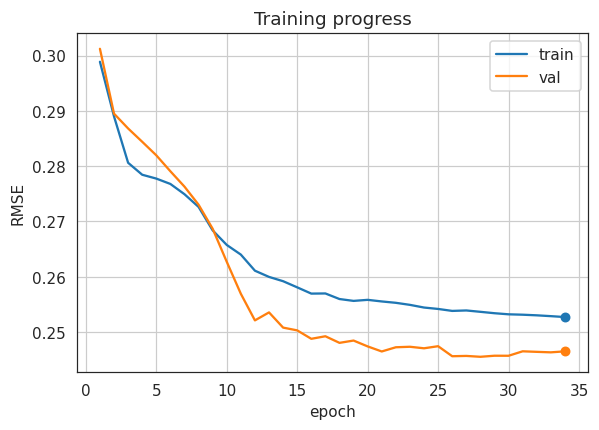

Epoch 1:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 001
TRAIN→ "R": RMSE=0.2989 MAE=0.2357 R2=-0.0628 | "B": Acc=0.3909 Prec=0.2506 Rec=0.6292 F1=0.3584 AUROC=0.4520
VALID→ "R": RMSE=0.3012 MAE=0.2025 R2=-0.1313 | "B": Acc=0.2735 Prec=0.2735 Rec=1.0000 F1=0.4295 AUROC=0.6110


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ "R": RMSE=0.2890 MAE=0.2290 R2=0.0063 | "B": Acc=0.3192 Prec=0.2705 Rec=0.8941 F1=0.4153 AUROC=0.4999
VALID→ "R": RMSE=0.2895 MAE=0.1964 R2=-0.0450 | "B": Acc=0.2735 Prec=0.2735 Rec=1.0000 F1=0.4295 AUROC=0.4409


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ "R": RMSE=0.2806 MAE=0.2176 R2=0.0631 | "B": Acc=0.3431 Prec=0.2665 Rec=0.8158 F1=0.4018 AUROC=0.4809
VALID→ "R": RMSE=0.2868 MAE=0.1931 R2=-0.0257 | "B": Acc=0.2735 Prec=0.2735 Rec=1.0000 F1=0.4295 AUROC=0.4352


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ "R": RMSE=0.2784 MAE=0.2165 R2=0.0774 | "B": Acc=0.3222 Prec=0.2666 Rec=0.8603 F1=0.4070 AUROC=0.4773
VALID→ "R": RMSE=0.2844 MAE=0.1917 R2=-0.0086 | "B": Acc=0.2735 Prec=0.2735 Rec=1.0000 F1=0.4295 AUROC=0.4198


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ "R": RMSE=0.2778 MAE=0.2171 R2=0.0821 | "B": Acc=0.3158 Prec=0.2670 Rec=0.8769 F1=0.4094 AUROC=0.4783
VALID→ "R": RMSE=0.2820 MAE=0.1904 R2=0.0087 | "B": Acc=0.2735 Prec=0.2735 Rec=1.0000 F1=0.4295 AUROC=0.3936


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ "R": RMSE=0.2768 MAE=0.2168 R2=0.0885 | "B": Acc=0.3185 Prec=0.2646 Rec=0.8546 F1=0.4041 AUROC=0.4674
VALID→ "R": RMSE=0.2791 MAE=0.1890 R2=0.0289 | "B": Acc=0.2733 Prec=0.2734 Rec=0.9996 F1=0.4293 AUROC=0.4287


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ "R": RMSE=0.2749 MAE=0.2149 R2=0.1006 | "B": Acc=0.3138 Prec=0.2665 Rec=0.8774 F1=0.4088 AUROC=0.4765
VALID→ "R": RMSE=0.2763 MAE=0.1875 R2=0.0481 | "B": Acc=0.2733 Prec=0.2733 Rec=0.9992 F1=0.4292 AUROC=0.3753


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ "R": RMSE=0.2726 MAE=0.2127 R2=0.1156 | "B": Acc=0.3256 Prec=0.2616 Rec=0.8193 F1=0.3965 AUROC=0.4586
VALID→ "R": RMSE=0.2730 MAE=0.1856 R2=0.0704 | "B": Acc=0.2728 Prec=0.2729 Rec=0.9971 F1=0.4285 AUROC=0.4678


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ "R": RMSE=0.2684 MAE=0.2061 R2=0.1429 | "B": Acc=0.3107 Prec=0.2658 Rec=0.8789 F1=0.4081 AUROC=0.4763
VALID→ "R": RMSE=0.2687 MAE=0.1834 R2=0.0998 | "B": Acc=0.2716 Prec=0.2719 Rec=0.9916 F1=0.4268 AUROC=0.3573


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ "R": RMSE=0.2658 MAE=0.2023 R2=0.1596 | "B": Acc=0.3132 Prec=0.2609 Rec=0.8399 F1=0.3981 AUROC=0.4520
VALID→ "R": RMSE=0.2627 MAE=0.1816 R2=0.1394 | "B": Acc=0.2708 Prec=0.2711 Rec=0.9873 F1=0.4254 AUROC=0.3868


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ "R": RMSE=0.2640 MAE=0.2035 R2=0.1706 | "B": Acc=0.3101 Prec=0.2608 Rec=0.8461 F1=0.3988 AUROC=0.4524
VALID→ "R": RMSE=0.2569 MAE=0.1810 R2=0.1769 | "B": Acc=0.2663 Prec=0.2668 Rec=0.9624 F1=0.4177 AUROC=0.3045


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ "R": RMSE=0.2611 MAE=0.2014 R2=0.1888 | "B": Acc=0.3081 Prec=0.2572 Rec=0.8256 F1=0.3922 AUROC=0.4349
VALID→ "R": RMSE=0.2521 MAE=0.1856 R2=0.2074 | "B": Acc=0.2639 Prec=0.2643 Rec=0.9486 F1=0.4134 AUROC=0.2758


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ "R": RMSE=0.2600 MAE=0.2004 R2=0.1958 | "B": Acc=0.3019 Prec=0.2561 Rec=0.8305 F1=0.3915 AUROC=0.4284
VALID→ "R": RMSE=0.2536 MAE=0.1786 R2=0.1983 | "B": Acc=0.2664 Prec=0.2669 Rec=0.9631 F1=0.4180 AUROC=0.3127


Epoch 14:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ "R": RMSE=0.2592 MAE=0.1992 R2=0.2006 | "B": Acc=0.2975 Prec=0.2573 Rec=0.8470 F1=0.3947 AUROC=0.4286
VALID→ "R": RMSE=0.2508 MAE=0.1841 R2=0.2156 | "B": Acc=0.2643 Prec=0.2648 Rec=0.9515 F1=0.4143 AUROC=0.2810


Epoch 15:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ "R": RMSE=0.2581 MAE=0.1984 R2=0.2074 | "B": Acc=0.2963 Prec=0.2561 Rec=0.8411 F1=0.3926 AUROC=0.4244
VALID→ "R": RMSE=0.2503 MAE=0.1833 R2=0.2187 | "B": Acc=0.2634 Prec=0.2639 Rec=0.9465 F1=0.4127 AUROC=0.2774


Epoch 16:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 016
TRAIN→ "R": RMSE=0.2570 MAE=0.1960 R2=0.2143 | "B": Acc=0.2943 Prec=0.2557 Rec=0.8422 F1=0.3923 AUROC=0.4204
VALID→ "R": RMSE=0.2488 MAE=0.1830 R2=0.2282 | "B": Acc=0.2646 Prec=0.2652 Rec=0.9539 F1=0.4150 AUROC=0.2741


Epoch 17:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 017
TRAIN→ "R": RMSE=0.2570 MAE=0.1969 R2=0.2142 | "B": Acc=0.2906 Prec=0.2559 Rec=0.8510 F1=0.3935 AUROC=0.4195
VALID→ "R": RMSE=0.2493 MAE=0.1822 R2=0.2253 | "B": Acc=0.2655 Prec=0.2661 Rec=0.9592 F1=0.4167 AUROC=0.2854


Epoch 18:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 018
TRAIN→ "R": RMSE=0.2560 MAE=0.1953 R2=0.2203 | "B": Acc=0.2884 Prec=0.2566 Rec=0.8601 F1=0.3953 AUROC=0.4217
VALID→ "R": RMSE=0.2481 MAE=0.1807 R2=0.2327 | "B": Acc=0.2657 Prec=0.2665 Rec=0.9616 F1=0.4173 AUROC=0.2913


Epoch 19:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 019
TRAIN→ "R": RMSE=0.2556 MAE=0.1949 R2=0.2224 | "B": Acc=0.2849 Prec=0.2563 Rec=0.8651 F1=0.3955 AUROC=0.4194
VALID→ "R": RMSE=0.2485 MAE=0.1790 R2=0.2302 | "B": Acc=0.2660 Prec=0.2669 Rec=0.9640 F1=0.4180 AUROC=0.3134


Epoch 20:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 020
TRAIN→ "R": RMSE=0.2558 MAE=0.1954 R2=0.2212 | "B": Acc=0.2831 Prec=0.2571 Rec=0.8738 F1=0.3973 AUROC=0.4248
VALID→ "R": RMSE=0.2474 MAE=0.1803 R2=0.2367 | "B": Acc=0.2651 Prec=0.2661 Rec=0.9600 F1=0.4167 AUROC=0.3148


Epoch 21:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 021
TRAIN→ "R": RMSE=0.2555 MAE=0.1957 R2=0.2230 | "B": Acc=0.2820 Prec=0.2584 Rec=0.8849 F1=0.3999 AUROC=0.4328
VALID→ "R": RMSE=0.2465 MAE=0.1819 R2=0.2423 | "B": Acc=0.2649 Prec=0.2660 Rec=0.9598 F1=0.4166 AUROC=0.3453


Epoch 22:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 022
TRAIN→ "R": RMSE=0.2553 MAE=0.1943 R2=0.2245 | "B": Acc=0.2849 Prec=0.2601 Rec=0.8915 F1=0.4027 AUROC=0.4496
VALID→ "R": RMSE=0.2473 MAE=0.1786 R2=0.2377 | "B": Acc=0.2662 Prec=0.2674 Rec=0.9673 F1=0.4189 AUROC=0.4163


Epoch 23:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 023
TRAIN→ "R": RMSE=0.2549 MAE=0.1935 R2=0.2267 | "B": Acc=0.2888 Prec=0.2609 Rec=0.8895 F1=0.4035 AUROC=0.4596
VALID→ "R": RMSE=0.2474 MAE=0.1794 R2=0.2371 | "B": Acc=0.2665 Prec=0.2676 Rec=0.9682 F1=0.4193 AUROC=0.4058


Epoch 24:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 024
TRAIN→ "R": RMSE=0.2544 MAE=0.1933 R2=0.2297 | "B": Acc=0.2902 Prec=0.2597 Rec=0.8777 F1=0.4008 AUROC=0.4551
VALID→ "R": RMSE=0.2471 MAE=0.1805 R2=0.2388 | "B": Acc=0.2653 Prec=0.2664 Rec=0.9620 F1=0.4173 AUROC=0.3938


Epoch 25:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 025
TRAIN→ "R": RMSE=0.2542 MAE=0.1931 R2=0.2312 | "B": Acc=0.2889 Prec=0.2588 Rec=0.8742 F1=0.3994 AUROC=0.4546
VALID→ "R": RMSE=0.2475 MAE=0.1789 R2=0.2365 | "B": Acc=0.2664 Prec=0.2676 Rec=0.9684 F1=0.4193 AUROC=0.3947


Epoch 26:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 026
TRAIN→ "R": RMSE=0.2538 MAE=0.1933 R2=0.2333 | "B": Acc=0.2868 Prec=0.2599 Rec=0.8862 F1=0.4019 AUROC=0.4552
VALID→ "R": RMSE=0.2456 MAE=0.1805 R2=0.2476 | "B": Acc=0.2634 Prec=0.2643 Rec=0.9493 F1=0.4134 AUROC=0.4066


Epoch 27:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 027
TRAIN→ "R": RMSE=0.2539 MAE=0.1945 R2=0.2329 | "B": Acc=0.2948 Prec=0.2614 Rec=0.8810 F1=0.4032 AUROC=0.4676
VALID→ "R": RMSE=0.2457 MAE=0.1798 R2=0.2473 | "B": Acc=0.2614 Prec=0.2632 Rec=0.9453 F1=0.4118 AUROC=0.4218


Epoch 28:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 028
TRAIN→ "R": RMSE=0.2537 MAE=0.1940 R2=0.2343 | "B": Acc=0.2959 Prec=0.2617 Rec=0.8805 F1=0.4034 AUROC=0.4704
VALID→ "R": RMSE=0.2455 MAE=0.1795 R2=0.2482 | "B": Acc=0.2624 Prec=0.2640 Rec=0.9494 F1=0.4131 AUROC=0.4548


Epoch 29:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 029
TRAIN→ "R": RMSE=0.2534 MAE=0.1938 R2=0.2359 | "B": Acc=0.2977 Prec=0.2618 Rec=0.8774 F1=0.4032 AUROC=0.4721
VALID→ "R": RMSE=0.2457 MAE=0.1781 R2=0.2471 | "B": Acc=0.2640 Prec=0.2655 Rec=0.9573 F1=0.4157 AUROC=0.4621


Epoch 30:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 030
TRAIN→ "R": RMSE=0.2532 MAE=0.1936 R2=0.2371 | "B": Acc=0.2964 Prec=0.2619 Rec=0.8808 F1=0.4037 AUROC=0.4718
VALID→ "R": RMSE=0.2457 MAE=0.1777 R2=0.2471 | "B": Acc=0.2631 Prec=0.2647 Rec=0.9529 F1=0.4143 AUROC=0.4594


Epoch 31:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 031
TRAIN→ "R": RMSE=0.2531 MAE=0.1935 R2=0.2375 | "B": Acc=0.2974 Prec=0.2618 Rec=0.8785 F1=0.4034 AUROC=0.4718
VALID→ "R": RMSE=0.2465 MAE=0.1763 R2=0.2422 | "B": Acc=0.2639 Prec=0.2653 Rec=0.9564 F1=0.4154 AUROC=0.4860


Epoch 32:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 032
TRAIN→ "R": RMSE=0.2530 MAE=0.1932 R2=0.2382 | "B": Acc=0.2956 Prec=0.2599 Rec=0.8684 F1=0.4000 AUROC=0.4638
VALID→ "R": RMSE=0.2464 MAE=0.1761 R2=0.2428 | "B": Acc=0.2636 Prec=0.2651 Rec=0.9551 F1=0.4150 AUROC=0.4840


Epoch 33:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 033
TRAIN→ "R": RMSE=0.2529 MAE=0.1930 R2=0.2391 | "B": Acc=0.2974 Prec=0.2622 Rec=0.8815 F1=0.4042 AUROC=0.4758
VALID→ "R": RMSE=0.2463 MAE=0.1759 R2=0.2433 | "B": Acc=0.2631 Prec=0.2645 Rec=0.9516 F1=0.4139 AUROC=0.4836


Epoch 34:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 034
TRAIN→ "R": RMSE=0.2527 MAE=0.1929 R2=0.2400 | "B": Acc=0.2952 Prec=0.2607 Rec=0.8750 F1=0.4017 AUROC=0.4657
VALID→ "R": RMSE=0.2465 MAE=0.1756 R2=0.2422 | "B": Acc=0.2624 Prec=0.2639 Rec=0.9487 F1=0.4129 AUROC=0.4709
Early stopping at epoch 34
Delete variables to free memory...


[I 2025-09-14 01:00:54,295] Trial 2 finished with value: 0.24554027616977692 and parameters: {'look_back': 120, 'DROPOUT_SHORT': 0.23692976369526964, 'DROPOUT_LONG': 0.16354695065301827, 'ATT_DROPOUT': 0.27010157688308367, 'INITIAL_LR': 0.0003037559303138773, 'ETA_MIN': 1.8196388345522165e-06, 'WEIGHT_DECAY': 0.004362570500682019, 'CLIPNORM': 7.43717625926685}. Best is trial 2 with value: 0.24554027616977692.



▶ Trial 3 starting with:
{'look_back': 120, 'DROPOUT_SHORT': 0.33025415619455517, 'DROPOUT_LONG': 0.0735552839458876, 'ATT_DROPOUT': 0.08872658718168452, 'INITIAL_LR': 1.0113977320775313e-05, 'ETA_MIN': 5.050961461471322e-06, 'WEIGHT_DECAY': 7.573622155920434e-05, 'CLIPNORM': 2.652509190966554}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_lstm_tensors, using: ['rsi_14', 'minus_di_15', 'eng_adx', 'eng_atr_div', 'adx_14', 'sma_100', 'vol_spike_14', 'macd_line_12_26_9', 'sma_20']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


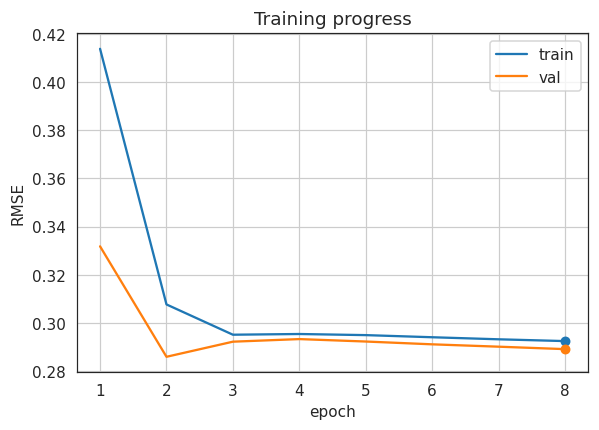

Epoch 1:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 001
TRAIN→ "R": RMSE=0.4138 MAE=0.3777 R2=-1.0375 | "B": Acc=0.7135 Prec=0.2782 Rec=0.0373 F1=0.0658 AUROC=0.5063
VALID→ "R": RMSE=0.3318 MAE=0.3010 R2=-0.3729 | "B": Acc=0.7265 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.6158


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ "R": RMSE=0.3077 MAE=0.2620 R2=-0.1266 | "B": Acc=0.7130 Prec=0.2729 Rec=0.0368 F1=0.0649 AUROC=0.5049
VALID→ "R": RMSE=0.2860 MAE=0.2119 R2=-0.0198 | "B": Acc=0.7265 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.6334


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ "R": RMSE=0.2951 MAE=0.2312 R2=-0.0365 | "B": Acc=0.7126 Prec=0.2751 Rec=0.0385 F1=0.0675 AUROC=0.5033
VALID→ "R": RMSE=0.2923 MAE=0.2061 R2=-0.0650 | "B": Acc=0.7265 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.6367


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ "R": RMSE=0.2954 MAE=0.2244 R2=-0.0386 | "B": Acc=0.7120 Prec=0.2769 Rec=0.0404 F1=0.0705 AUROC=0.5043
VALID→ "R": RMSE=0.2933 MAE=0.2051 R2=-0.0729 | "B": Acc=0.7265 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.6376


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ "R": RMSE=0.2950 MAE=0.2229 R2=-0.0353 | "B": Acc=0.7118 Prec=0.2778 Rec=0.0412 F1=0.0718 AUROC=0.5056
VALID→ "R": RMSE=0.2923 MAE=0.2048 R2=-0.0655 | "B": Acc=0.7265 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.6365


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ "R": RMSE=0.2941 MAE=0.2224 R2=-0.0291 | "B": Acc=0.7117 Prec=0.2775 Rec=0.0413 F1=0.0719 AUROC=0.5048
VALID→ "R": RMSE=0.2912 MAE=0.2046 R2=-0.0570 | "B": Acc=0.7265 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.6334


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ "R": RMSE=0.2932 MAE=0.2219 R2=-0.0232 | "B": Acc=0.7123 Prec=0.2789 Rec=0.0403 F1=0.0705 AUROC=0.5042
VALID→ "R": RMSE=0.2902 MAE=0.2043 R2=-0.0499 | "B": Acc=0.7265 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.6288


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ "R": RMSE=0.2925 MAE=0.2216 R2=-0.0180 | "B": Acc=0.7133 Prec=0.2776 Rec=0.0376 F1=0.0662 AUROC=0.5056
VALID→ "R": RMSE=0.2892 MAE=0.2040 R2=-0.0426 | "B": Acc=0.7265 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.6217
Early stopping at epoch 8
Delete variables to free memory...


[I 2025-09-14 01:08:19,891] Trial 3 finished with value: 0.28598344326019287 and parameters: {'look_back': 120, 'DROPOUT_SHORT': 0.33025415619455517, 'DROPOUT_LONG': 0.0735552839458876, 'ATT_DROPOUT': 0.08872658718168452, 'INITIAL_LR': 1.0113977320775313e-05, 'ETA_MIN': 5.050961461471322e-06, 'WEIGHT_DECAY': 7.573622155920434e-05, 'CLIPNORM': 2.652509190966554}. Best is trial 2 with value: 0.24554027616977692.



▶ Trial 4 starting with:
{'look_back': 120, 'DROPOUT_SHORT': 0.14934742065459877, 'DROPOUT_LONG': 0.16219466338835561, 'ATT_DROPOUT': 0.15454007876917714, 'INITIAL_LR': 1.8736488912026368e-05, 'ETA_MIN': 4.959631351549178e-06, 'WEIGHT_DECAY': 0.0003874020861010938, 'CLIPNORM': 9.133234474251395}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_lstm_tensors, using: ['rsi_14', 'minus_di_15', 'eng_adx', 'eng_atr_div', 'adx_14', 'sma_100', 'vol_spike_14', 'macd_line_12_26_9', 'sma_20']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


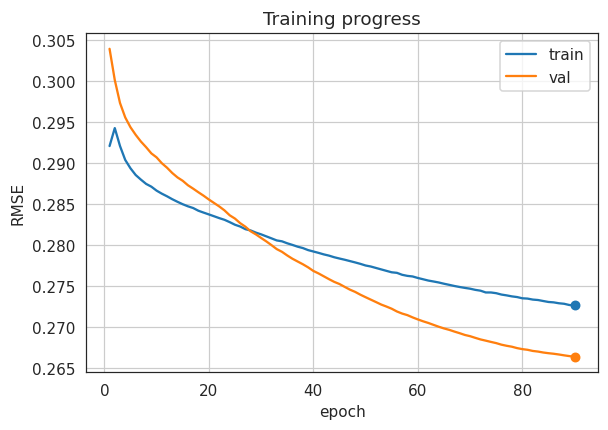

Epoch 1:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 001
TRAIN→ "R": RMSE=0.2921 MAE=0.2300 R2=-0.0150 | "B": Acc=0.4220 Prec=0.2619 Rec=0.6257 F1=0.3693 AUROC=0.4784
VALID→ "R": RMSE=0.3039 MAE=0.2030 R2=-0.1518 | "B": Acc=0.2735 Prec=0.2735 Rec=1.0000 F1=0.4295 AUROC=0.3761


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ "R": RMSE=0.2943 MAE=0.2228 R2=-0.0303 | "B": Acc=0.4208 Prec=0.2686 Rec=0.6626 F1=0.3822 AUROC=0.4950
VALID→ "R": RMSE=0.3001 MAE=0.2008 R2=-0.1231 | "B": Acc=0.2735 Prec=0.2735 Rec=1.0000 F1=0.4295 AUROC=0.3739


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ "R": RMSE=0.2921 MAE=0.2208 R2=-0.0150 | "B": Acc=0.4156 Prec=0.2684 Rec=0.6728 F1=0.3837 AUROC=0.4945
VALID→ "R": RMSE=0.2973 MAE=0.1993 R2=-0.1022 | "B": Acc=0.2735 Prec=0.2735 Rec=1.0000 F1=0.4295 AUROC=0.3736


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ "R": RMSE=0.2904 MAE=0.2196 R2=-0.0032 | "B": Acc=0.4159 Prec=0.2692 Rec=0.6763 F1=0.3851 AUROC=0.4962
VALID→ "R": RMSE=0.2956 MAE=0.1983 R2=-0.0892 | "B": Acc=0.2735 Prec=0.2735 Rec=1.0000 F1=0.4295 AUROC=0.3747


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ "R": RMSE=0.2894 MAE=0.2187 R2=0.0038 | "B": Acc=0.4200 Prec=0.2692 Rec=0.6678 F1=0.3837 AUROC=0.4969
VALID→ "R": RMSE=0.2944 MAE=0.1976 R2=-0.0804 | "B": Acc=0.2735 Prec=0.2735 Rec=1.0000 F1=0.4295 AUROC=0.3765


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ "R": RMSE=0.2885 MAE=0.2179 R2=0.0094 | "B": Acc=0.4297 Prec=0.2696 Rec=0.6490 F1=0.3809 AUROC=0.4979
VALID→ "R": RMSE=0.2934 MAE=0.1971 R2=-0.0736 | "B": Acc=0.2735 Prec=0.2735 Rec=1.0000 F1=0.4295 AUROC=0.3792


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ "R": RMSE=0.2880 MAE=0.2174 R2=0.0133 | "B": Acc=0.4397 Prec=0.2698 Rec=0.6283 F1=0.3775 AUROC=0.4983
VALID→ "R": RMSE=0.2926 MAE=0.1967 R2=-0.0676 | "B": Acc=0.2735 Prec=0.2735 Rec=1.0000 F1=0.4295 AUROC=0.3844


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ "R": RMSE=0.2874 MAE=0.2168 R2=0.0169 | "B": Acc=0.4532 Prec=0.2704 Rec=0.6020 F1=0.3732 AUROC=0.4998
VALID→ "R": RMSE=0.2919 MAE=0.1964 R2=-0.0626 | "B": Acc=0.2735 Prec=0.2735 Rec=1.0000 F1=0.4295 AUROC=0.3945


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ "R": RMSE=0.2871 MAE=0.2164 R2=0.0192 | "B": Acc=0.4676 Prec=0.2710 Rec=0.5733 F1=0.3680 AUROC=0.5008
VALID→ "R": RMSE=0.2912 MAE=0.1961 R2=-0.0571 | "B": Acc=0.2737 Prec=0.2735 Rec=1.0000 F1=0.4296 AUROC=0.4096


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ "R": RMSE=0.2866 MAE=0.2161 R2=0.0225 | "B": Acc=0.4821 Prec=0.2712 Rec=0.5422 F1=0.3615 AUROC=0.5017
VALID→ "R": RMSE=0.2907 MAE=0.1959 R2=-0.0536 | "B": Acc=0.2758 Prec=0.2738 Rec=0.9978 F1=0.4297 AUROC=0.4295


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ "R": RMSE=0.2863 MAE=0.2157 R2=0.0250 | "B": Acc=0.4970 Prec=0.2715 Rec=0.5109 F1=0.3546 AUROC=0.5019
VALID→ "R": RMSE=0.2900 MAE=0.1957 R2=-0.0484 | "B": Acc=0.3095 Prec=0.2686 Rec=0.8855 F1=0.4122 AUROC=0.4527


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ "R": RMSE=0.2859 MAE=0.2155 R2=0.0272 | "B": Acc=0.5103 Prec=0.2723 Rec=0.4847 F1=0.3487 AUROC=0.5035
VALID→ "R": RMSE=0.2894 MAE=0.1955 R2=-0.0445 | "B": Acc=0.5099 Prec=0.2563 Rec=0.4164 F1=0.3173 AUROC=0.4743


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ "R": RMSE=0.2856 MAE=0.2152 R2=0.0296 | "B": Acc=0.5221 Prec=0.2724 Rec=0.4592 F1=0.3420 AUROC=0.5031
VALID→ "R": RMSE=0.2888 MAE=0.1954 R2=-0.0398 | "B": Acc=0.6791 Prec=0.2767 Rec=0.1075 F1=0.1549 AUROC=0.4951


Epoch 14:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ "R": RMSE=0.2853 MAE=0.2150 R2=0.0318 | "B": Acc=0.5336 Prec=0.2724 Rec=0.4337 F1=0.3346 AUROC=0.5033
VALID→ "R": RMSE=0.2882 MAE=0.1952 R2=-0.0359 | "B": Acc=0.7187 Prec=0.3262 Rec=0.0268 F1=0.0496 AUROC=0.5083


Epoch 15:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ "R": RMSE=0.2850 MAE=0.2148 R2=0.0338 | "B": Acc=0.5432 Prec=0.2728 Rec=0.4138 F1=0.3288 AUROC=0.5041
VALID→ "R": RMSE=0.2878 MAE=0.1951 R2=-0.0330 | "B": Acc=0.7247 Prec=0.3676 Rec=0.0092 F1=0.0180 AUROC=0.5177


Epoch 16:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 016
TRAIN→ "R": RMSE=0.2847 MAE=0.2146 R2=0.0355 | "B": Acc=0.5518 Prec=0.2740 Rec=0.3987 F1=0.3248 AUROC=0.5046
VALID→ "R": RMSE=0.2873 MAE=0.1950 R2=-0.0291 | "B": Acc=0.7259 Prec=0.3450 Rec=0.0026 F1=0.0052 AUROC=0.5278


Epoch 17:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 017
TRAIN→ "R": RMSE=0.2845 MAE=0.2144 R2=0.0369 | "B": Acc=0.5590 Prec=0.2739 Rec=0.3822 F1=0.3191 AUROC=0.5047
VALID→ "R": RMSE=0.2869 MAE=0.1949 R2=-0.0261 | "B": Acc=0.7259 Prec=0.2368 Rec=0.0010 F1=0.0020 AUROC=0.5317


Epoch 18:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 018
TRAIN→ "R": RMSE=0.2842 MAE=0.2141 R2=0.0391 | "B": Acc=0.5644 Prec=0.2740 Rec=0.3702 F1=0.3149 AUROC=0.5045
VALID→ "R": RMSE=0.2864 MAE=0.1948 R2=-0.0230 | "B": Acc=0.7259 Prec=0.1765 Rec=0.0006 F1=0.0012 AUROC=0.5332


Epoch 19:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 019
TRAIN→ "R": RMSE=0.2839 MAE=0.2140 R2=0.0407 | "B": Acc=0.5690 Prec=0.2739 Rec=0.3597 F1=0.3110 AUROC=0.5045
VALID→ "R": RMSE=0.2860 MAE=0.1947 R2=-0.0200 | "B": Acc=0.7259 Prec=0.1527 Rec=0.0005 F1=0.0010 AUROC=0.5342


Epoch 20:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 020
TRAIN→ "R": RMSE=0.2837 MAE=0.2138 R2=0.0422 | "B": Acc=0.5723 Prec=0.2736 Rec=0.3514 F1=0.3076 AUROC=0.5036
VALID→ "R": RMSE=0.2855 MAE=0.1945 R2=-0.0167 | "B": Acc=0.7260 Prec=0.1469 Rec=0.0004 F1=0.0009 AUROC=0.5343


Epoch 21:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 021
TRAIN→ "R": RMSE=0.2835 MAE=0.2137 R2=0.0437 | "B": Acc=0.5760 Prec=0.2741 Rec=0.3445 F1=0.3053 AUROC=0.5045
VALID→ "R": RMSE=0.2851 MAE=0.1944 R2=-0.0136 | "B": Acc=0.7260 Prec=0.1483 Rec=0.0004 F1=0.0009 AUROC=0.5312


Epoch 22:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 022
TRAIN→ "R": RMSE=0.2833 MAE=0.2135 R2=0.0452 | "B": Acc=0.5779 Prec=0.2734 Rec=0.3385 F1=0.3025 AUROC=0.5036
VALID→ "R": RMSE=0.2847 MAE=0.1943 R2=-0.0106 | "B": Acc=0.7260 Prec=0.1497 Rec=0.0004 F1=0.0009 AUROC=0.5295


Epoch 23:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 023
TRAIN→ "R": RMSE=0.2831 MAE=0.2133 R2=0.0466 | "B": Acc=0.5811 Prec=0.2745 Rec=0.3341 F1=0.3014 AUROC=0.5042
VALID→ "R": RMSE=0.2842 MAE=0.1942 R2=-0.0072 | "B": Acc=0.7260 Prec=0.1546 Rec=0.0005 F1=0.0009 AUROC=0.5323


Epoch 24:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 024
TRAIN→ "R": RMSE=0.2828 MAE=0.2131 R2=0.0485 | "B": Acc=0.5832 Prec=0.2751 Rec=0.3312 F1=0.3006 AUROC=0.5050
VALID→ "R": RMSE=0.2836 MAE=0.1940 R2=-0.0030 | "B": Acc=0.7260 Prec=0.1594 Rec=0.0005 F1=0.0010 AUROC=0.5351


Epoch 25:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 025
TRAIN→ "R": RMSE=0.2825 MAE=0.2129 R2=0.0506 | "B": Acc=0.5861 Prec=0.2753 Rec=0.3249 F1=0.2980 AUROC=0.5051
VALID→ "R": RMSE=0.2832 MAE=0.1939 R2=-0.0002 | "B": Acc=0.7260 Prec=0.1604 Rec=0.0005 F1=0.0010 AUROC=0.5361


Epoch 26:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 026
TRAIN→ "R": RMSE=0.2822 MAE=0.2127 R2=0.0521 | "B": Acc=0.5889 Prec=0.2752 Rec=0.3184 F1=0.2952 AUROC=0.5058
VALID→ "R": RMSE=0.2827 MAE=0.1938 R2=0.0038 | "B": Acc=0.7260 Prec=0.1635 Rec=0.0005 F1=0.0010 AUROC=0.5362


Epoch 27:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 027
TRAIN→ "R": RMSE=0.2819 MAE=0.2125 R2=0.0543 | "B": Acc=0.5917 Prec=0.2760 Rec=0.3141 F1=0.2938 AUROC=0.5061
VALID→ "R": RMSE=0.2822 MAE=0.1936 R2=0.0068 | "B": Acc=0.7260 Prec=0.1755 Rec=0.0005 F1=0.0011 AUROC=0.5386


Epoch 28:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 028
TRAIN→ "R": RMSE=0.2818 MAE=0.2123 R2=0.0553 | "B": Acc=0.5932 Prec=0.2759 Rec=0.3106 F1=0.2922 AUROC=0.5062
VALID→ "R": RMSE=0.2817 MAE=0.1935 R2=0.0108 | "B": Acc=0.7260 Prec=0.1915 Rec=0.0006 F1=0.0012 AUROC=0.5386


Epoch 29:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 029
TRAIN→ "R": RMSE=0.2815 MAE=0.2122 R2=0.0571 | "B": Acc=0.5938 Prec=0.2756 Rec=0.3084 F1=0.2911 AUROC=0.5052
VALID→ "R": RMSE=0.2813 MAE=0.1934 R2=0.0134 | "B": Acc=0.7260 Prec=0.1970 Rec=0.0006 F1=0.0012 AUROC=0.5388


Epoch 30:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 030
TRAIN→ "R": RMSE=0.2813 MAE=0.2119 R2=0.0585 | "B": Acc=0.5944 Prec=0.2754 Rec=0.3065 F1=0.2901 AUROC=0.5052
VALID→ "R": RMSE=0.2809 MAE=0.1933 R2=0.0165 | "B": Acc=0.7260 Prec=0.1994 Rec=0.0006 F1=0.0013 AUROC=0.5370


Epoch 31:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 031
TRAIN→ "R": RMSE=0.2810 MAE=0.2118 R2=0.0602 | "B": Acc=0.5962 Prec=0.2754 Rec=0.3027 F1=0.2884 AUROC=0.5057
VALID→ "R": RMSE=0.2804 MAE=0.1932 R2=0.0194 | "B": Acc=0.7260 Prec=0.2042 Rec=0.0006 F1=0.0013 AUROC=0.5355


Epoch 32:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 032
TRAIN→ "R": RMSE=0.2808 MAE=0.2116 R2=0.0618 | "B": Acc=0.5967 Prec=0.2752 Rec=0.3009 F1=0.2875 AUROC=0.5043
VALID→ "R": RMSE=0.2800 MAE=0.1931 R2=0.0226 | "B": Acc=0.7261 Prec=0.2351 Rec=0.0008 F1=0.0016 AUROC=0.5330


Epoch 33:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 033
TRAIN→ "R": RMSE=0.2805 MAE=0.2114 R2=0.0635 | "B": Acc=0.5948 Prec=0.2755 Rec=0.3058 F1=0.2898 AUROC=0.5049
VALID→ "R": RMSE=0.2795 MAE=0.1930 R2=0.0260 | "B": Acc=0.7261 Prec=0.2554 Rec=0.0009 F1=0.0018 AUROC=0.5322


Epoch 34:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 034
TRAIN→ "R": RMSE=0.2804 MAE=0.2113 R2=0.0642 | "B": Acc=0.5933 Prec=0.2741 Rec=0.3058 F1=0.2891 AUROC=0.5036
VALID→ "R": RMSE=0.2792 MAE=0.1930 R2=0.0283 | "B": Acc=0.7261 Prec=0.2985 Rec=0.0011 F1=0.0023 AUROC=0.5301


Epoch 35:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 035
TRAIN→ "R": RMSE=0.2802 MAE=0.2112 R2=0.0658 | "B": Acc=0.5907 Prec=0.2739 Rec=0.3111 F1=0.2913 AUROC=0.5035
VALID→ "R": RMSE=0.2787 MAE=0.1929 R2=0.0314 | "B": Acc=0.7261 Prec=0.3088 Rec=0.0012 F1=0.0025 AUROC=0.5274


Epoch 36:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 036
TRAIN→ "R": RMSE=0.2800 MAE=0.2111 R2=0.0671 | "B": Acc=0.5902 Prec=0.2743 Rec=0.3131 F1=0.2924 AUROC=0.5036
VALID→ "R": RMSE=0.2783 MAE=0.1928 R2=0.0341 | "B": Acc=0.7261 Prec=0.3214 Rec=0.0015 F1=0.0029 AUROC=0.5228


Epoch 37:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 037
TRAIN→ "R": RMSE=0.2798 MAE=0.2109 R2=0.0686 | "B": Acc=0.5895 Prec=0.2738 Rec=0.3136 F1=0.2924 AUROC=0.5027
VALID→ "R": RMSE=0.2780 MAE=0.1927 R2=0.0365 | "B": Acc=0.7261 Prec=0.3257 Rec=0.0016 F1=0.0032 AUROC=0.5188


Epoch 38:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 038
TRAIN→ "R": RMSE=0.2796 MAE=0.2108 R2=0.0697 | "B": Acc=0.5884 Prec=0.2722 Rec=0.3121 F1=0.2908 AUROC=0.5013
VALID→ "R": RMSE=0.2776 MAE=0.1927 R2=0.0388 | "B": Acc=0.7260 Prec=0.3189 Rec=0.0018 F1=0.0035 AUROC=0.5145


Epoch 39:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 039
TRAIN→ "R": RMSE=0.2794 MAE=0.2106 R2=0.0713 | "B": Acc=0.5874 Prec=0.2723 Rec=0.3143 F1=0.2918 AUROC=0.5012
VALID→ "R": RMSE=0.2773 MAE=0.1926 R2=0.0414 | "B": Acc=0.7259 Prec=0.3325 Rec=0.0025 F1=0.0050 AUROC=0.5110


Epoch 40:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 040
TRAIN→ "R": RMSE=0.2792 MAE=0.2105 R2=0.0725 | "B": Acc=0.5852 Prec=0.2718 Rec=0.3179 F1=0.2931 AUROC=0.5004
VALID→ "R": RMSE=0.2768 MAE=0.1925 R2=0.0444 | "B": Acc=0.7256 Prec=0.3207 Rec=0.0032 F1=0.0062 AUROC=0.5061


Epoch 41:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 041
TRAIN→ "R": RMSE=0.2790 MAE=0.2104 R2=0.0736 | "B": Acc=0.5827 Prec=0.2706 Rec=0.3203 F1=0.2933 AUROC=0.4995
VALID→ "R": RMSE=0.2765 MAE=0.1925 R2=0.0466 | "B": Acc=0.7253 Prec=0.3181 Rec=0.0038 F1=0.0076 AUROC=0.5024


Epoch 42:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 042
TRAIN→ "R": RMSE=0.2788 MAE=0.2103 R2=0.0748 | "B": Acc=0.5818 Prec=0.2711 Rec=0.3238 F1=0.2952 AUROC=0.4997
VALID→ "R": RMSE=0.2762 MAE=0.1924 R2=0.0490 | "B": Acc=0.7249 Prec=0.3082 Rec=0.0050 F1=0.0098 AUROC=0.4990


Epoch 43:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 043
TRAIN→ "R": RMSE=0.2787 MAE=0.2102 R2=0.0758 | "B": Acc=0.5795 Prec=0.2709 Rec=0.3281 F1=0.2968 AUROC=0.4992
VALID→ "R": RMSE=0.2758 MAE=0.1923 R2=0.0514 | "B": Acc=0.7242 Prec=0.3122 Rec=0.0071 F1=0.0139 AUROC=0.4960


Epoch 44:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 044
TRAIN→ "R": RMSE=0.2785 MAE=0.2101 R2=0.0771 | "B": Acc=0.5762 Prec=0.2701 Rec=0.3330 F1=0.2983 AUROC=0.4984
VALID→ "R": RMSE=0.2755 MAE=0.1923 R2=0.0536 | "B": Acc=0.7232 Prec=0.3004 Rec=0.0091 F1=0.0177 AUROC=0.4922


Epoch 45:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 045
TRAIN→ "R": RMSE=0.2783 MAE=0.2100 R2=0.0782 | "B": Acc=0.5730 Prec=0.2688 Rec=0.3366 F1=0.2989 AUROC=0.4971
VALID→ "R": RMSE=0.2752 MAE=0.1922 R2=0.0554 | "B": Acc=0.7215 Prec=0.2928 Rec=0.0129 F1=0.0248 AUROC=0.4871


Epoch 46:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 046
TRAIN→ "R": RMSE=0.2782 MAE=0.2099 R2=0.0791 | "B": Acc=0.5721 Prec=0.2700 Rec=0.3418 F1=0.3017 AUROC=0.4984
VALID→ "R": RMSE=0.2749 MAE=0.1922 R2=0.0578 | "B": Acc=0.7198 Prec=0.2884 Rec=0.0169 F1=0.0319 AUROC=0.4855


Epoch 47:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 047
TRAIN→ "R": RMSE=0.2780 MAE=0.2097 R2=0.0802 | "B": Acc=0.5691 Prec=0.2684 Rec=0.3438 F1=0.3015 AUROC=0.4965
VALID→ "R": RMSE=0.2745 MAE=0.1921 R2=0.0601 | "B": Acc=0.7176 Prec=0.2743 Rec=0.0199 F1=0.0372 AUROC=0.4815


Epoch 48:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 048
TRAIN→ "R": RMSE=0.2779 MAE=0.2097 R2=0.0813 | "B": Acc=0.5674 Prec=0.2676 Rec=0.3452 F1=0.3015 AUROC=0.4952
VALID→ "R": RMSE=0.2743 MAE=0.1921 R2=0.0620 | "B": Acc=0.7134 Prec=0.2579 Rec=0.0257 F1=0.0467 AUROC=0.4774


Epoch 49:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 049
TRAIN→ "R": RMSE=0.2777 MAE=0.2095 R2=0.0825 | "B": Acc=0.5643 Prec=0.2668 Rec=0.3496 F1=0.3027 AUROC=0.4944
VALID→ "R": RMSE=0.2739 MAE=0.1920 R2=0.0643 | "B": Acc=0.7089 Prec=0.2472 Rec=0.0315 F1=0.0558 AUROC=0.4737


Epoch 50:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 050
TRAIN→ "R": RMSE=0.2775 MAE=0.2094 R2=0.0838 | "B": Acc=0.5631 Prec=0.2662 Rec=0.3505 F1=0.3026 AUROC=0.4939
VALID→ "R": RMSE=0.2736 MAE=0.1920 R2=0.0664 | "B": Acc=0.7043 Prec=0.2377 Rec=0.0368 F1=0.0637 AUROC=0.4699


Epoch 51:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 051
TRAIN→ "R": RMSE=0.2774 MAE=0.2094 R2=0.0846 | "B": Acc=0.5612 Prec=0.2662 Rec=0.3544 F1=0.3040 AUROC=0.4933
VALID→ "R": RMSE=0.2733 MAE=0.1919 R2=0.0685 | "B": Acc=0.7000 Prec=0.2339 Rec=0.0427 F1=0.0722 AUROC=0.4673


Epoch 52:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 052
TRAIN→ "R": RMSE=0.2772 MAE=0.2093 R2=0.0858 | "B": Acc=0.5601 Prec=0.2656 Rec=0.3551 F1=0.3039 AUROC=0.4929
VALID→ "R": RMSE=0.2730 MAE=0.1918 R2=0.0705 | "B": Acc=0.6950 Prec=0.2288 Rec=0.0486 F1=0.0802 AUROC=0.4636


Epoch 53:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 053
TRAIN→ "R": RMSE=0.2770 MAE=0.2092 R2=0.0869 | "B": Acc=0.5591 Prec=0.2653 Rec=0.3565 F1=0.3042 AUROC=0.4920
VALID→ "R": RMSE=0.2727 MAE=0.1918 R2=0.0726 | "B": Acc=0.6882 Prec=0.2231 Rec=0.0565 F1=0.0902 AUROC=0.4596


Epoch 54:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 054
TRAIN→ "R": RMSE=0.2768 MAE=0.2091 R2=0.0881 | "B": Acc=0.5571 Prec=0.2642 Rec=0.3573 F1=0.3037 AUROC=0.4908
VALID→ "R": RMSE=0.2725 MAE=0.1918 R2=0.0742 | "B": Acc=0.6833 Prec=0.2203 Rec=0.0622 F1=0.0970 AUROC=0.4573


Epoch 55:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 055
TRAIN→ "R": RMSE=0.2767 MAE=0.2090 R2=0.0892 | "B": Acc=0.5550 Prec=0.2634 Rec=0.3593 F1=0.3039 AUROC=0.4894
VALID→ "R": RMSE=0.2722 MAE=0.1917 R2=0.0760 | "B": Acc=0.6748 Prec=0.2166 Rec=0.0724 F1=0.1085 AUROC=0.4530


Epoch 56:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 056
TRAIN→ "R": RMSE=0.2766 MAE=0.2090 R2=0.0897 | "B": Acc=0.5513 Prec=0.2620 Rec=0.3629 F1=0.3043 AUROC=0.4880
VALID→ "R": RMSE=0.2719 MAE=0.1917 R2=0.0783 | "B": Acc=0.6644 Prec=0.2137 Rec=0.0849 F1=0.1215 AUROC=0.4497


Epoch 57:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 057
TRAIN→ "R": RMSE=0.2764 MAE=0.2089 R2=0.0913 | "B": Acc=0.5496 Prec=0.2621 Rec=0.3666 F1=0.3056 AUROC=0.4876
VALID→ "R": RMSE=0.2716 MAE=0.1916 R2=0.0800 | "B": Acc=0.6586 Prec=0.2117 Rec=0.0912 F1=0.1275 AUROC=0.4466


Epoch 58:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 058
TRAIN→ "R": RMSE=0.2762 MAE=0.2088 R2=0.0921 | "B": Acc=0.5490 Prec=0.2622 Rec=0.3681 F1=0.3062 AUROC=0.4875
VALID→ "R": RMSE=0.2714 MAE=0.1916 R2=0.0813 | "B": Acc=0.6525 Prec=0.2106 Rec=0.0985 F1=0.1342 AUROC=0.4442


Epoch 59:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 059
TRAIN→ "R": RMSE=0.2762 MAE=0.2087 R2=0.0926 | "B": Acc=0.5469 Prec=0.2609 Rec=0.3686 F1=0.3055 AUROC=0.4860
VALID→ "R": RMSE=0.2712 MAE=0.1916 R2=0.0832 | "B": Acc=0.6424 Prec=0.2079 Rec=0.1095 F1=0.1435 AUROC=0.4403


Epoch 60:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 060
TRAIN→ "R": RMSE=0.2760 MAE=0.2087 R2=0.0938 | "B": Acc=0.5462 Prec=0.2612 Rec=0.3710 F1=0.3066 AUROC=0.4862
VALID→ "R": RMSE=0.2709 MAE=0.1915 R2=0.0848 | "B": Acc=0.6386 Prec=0.2067 Rec=0.1134 F1=0.1464 AUROC=0.4376


Epoch 61:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 061
TRAIN→ "R": RMSE=0.2758 MAE=0.2086 R2=0.0948 | "B": Acc=0.5436 Prec=0.2594 Rec=0.3709 F1=0.3053 AUROC=0.4838
VALID→ "R": RMSE=0.2707 MAE=0.1915 R2=0.0864 | "B": Acc=0.6264 Prec=0.2053 Rec=0.1276 F1=0.1574 AUROC=0.4337


Epoch 62:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 062
TRAIN→ "R": RMSE=0.2757 MAE=0.2085 R2=0.0959 | "B": Acc=0.5433 Prec=0.2601 Rec=0.3735 F1=0.3067 AUROC=0.4844
VALID→ "R": RMSE=0.2705 MAE=0.1914 R2=0.0877 | "B": Acc=0.6217 Prec=0.2043 Rec=0.1324 F1=0.1607 AUROC=0.4309


Epoch 63:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 063
TRAIN→ "R": RMSE=0.2755 MAE=0.2084 R2=0.0966 | "B": Acc=0.5414 Prec=0.2584 Rec=0.3722 F1=0.3050 AUROC=0.4825
VALID→ "R": RMSE=0.2703 MAE=0.1914 R2=0.0893 | "B": Acc=0.6146 Prec=0.2030 Rec=0.1400 F1=0.1657 AUROC=0.4288


Epoch 64:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 064
TRAIN→ "R": RMSE=0.2754 MAE=0.2083 R2=0.0974 | "B": Acc=0.5400 Prec=0.2581 Rec=0.3739 F1=0.3054 AUROC=0.4813
VALID→ "R": RMSE=0.2700 MAE=0.1914 R2=0.0909 | "B": Acc=0.6044 Prec=0.2021 Rec=0.1516 F1=0.1732 AUROC=0.4259


Epoch 65:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 065
TRAIN→ "R": RMSE=0.2753 MAE=0.2083 R2=0.0984 | "B": Acc=0.5374 Prec=0.2572 Rec=0.3763 F1=0.3055 AUROC=0.4800
VALID→ "R": RMSE=0.2698 MAE=0.1913 R2=0.0922 | "B": Acc=0.5955 Prec=0.2010 Rec=0.1610 F1=0.1788 AUROC=0.4229


Epoch 66:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 066
TRAIN→ "R": RMSE=0.2751 MAE=0.2082 R2=0.0993 | "B": Acc=0.5356 Prec=0.2567 Rec=0.3785 F1=0.3059 AUROC=0.4791
VALID→ "R": RMSE=0.2696 MAE=0.1913 R2=0.0934 | "B": Acc=0.5903 Prec=0.2006 Rec=0.1669 F1=0.1822 AUROC=0.4211


Epoch 67:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 067
TRAIN→ "R": RMSE=0.2750 MAE=0.2081 R2=0.1002 | "B": Acc=0.5355 Prec=0.2559 Rec=0.3764 F1=0.3047 AUROC=0.4779
VALID→ "R": RMSE=0.2694 MAE=0.1912 R2=0.0948 | "B": Acc=0.5868 Prec=0.2002 Rec=0.1706 F1=0.1842 AUROC=0.4188


Epoch 68:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 068
TRAIN→ "R": RMSE=0.2749 MAE=0.2080 R2=0.1010 | "B": Acc=0.5342 Prec=0.2551 Rec=0.3763 F1=0.3041 AUROC=0.4767
VALID→ "R": RMSE=0.2692 MAE=0.1912 R2=0.0962 | "B": Acc=0.5773 Prec=0.1993 Rec=0.1809 F1=0.1897 AUROC=0.4166


Epoch 69:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 069
TRAIN→ "R": RMSE=0.2748 MAE=0.2079 R2=0.1017 | "B": Acc=0.5314 Prec=0.2543 Rec=0.3794 F1=0.3045 AUROC=0.4762
VALID→ "R": RMSE=0.2690 MAE=0.1912 R2=0.0976 | "B": Acc=0.5702 Prec=0.1994 Rec=0.1896 F1=0.1943 AUROC=0.4149


Epoch 70:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 070
TRAIN→ "R": RMSE=0.2747 MAE=0.2079 R2=0.1024 | "B": Acc=0.5304 Prec=0.2537 Rec=0.3795 F1=0.3041 AUROC=0.4748
VALID→ "R": RMSE=0.2689 MAE=0.1911 R2=0.0986 | "B": Acc=0.5640 Prec=0.1992 Rec=0.1968 F1=0.1980 AUROC=0.4137


Epoch 71:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 071
TRAIN→ "R": RMSE=0.2745 MAE=0.2078 R2=0.1033 | "B": Acc=0.5284 Prec=0.2537 Rec=0.3831 F1=0.3052 AUROC=0.4744
VALID→ "R": RMSE=0.2687 MAE=0.1911 R2=0.1000 | "B": Acc=0.5525 Prec=0.1987 Rec=0.2098 F1=0.2041 AUROC=0.4117


Epoch 72:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 072
TRAIN→ "R": RMSE=0.2744 MAE=0.2078 R2=0.1040 | "B": Acc=0.5260 Prec=0.2525 Rec=0.3840 F1=0.3047 AUROC=0.4730
VALID→ "R": RMSE=0.2685 MAE=0.1911 R2=0.1013 | "B": Acc=0.5465 Prec=0.1988 Rec=0.2171 F1=0.2075 AUROC=0.4102


Epoch 73:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 073
TRAIN→ "R": RMSE=0.2742 MAE=0.2076 R2=0.1054 | "B": Acc=0.5253 Prec=0.2528 Rec=0.3861 F1=0.3055 AUROC=0.4731
VALID→ "R": RMSE=0.2683 MAE=0.1910 R2=0.1023 | "B": Acc=0.5401 Prec=0.1987 Rec=0.2248 F1=0.2109 AUROC=0.4084


Epoch 74:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 074
TRAIN→ "R": RMSE=0.2742 MAE=0.2076 R2=0.1054 | "B": Acc=0.5230 Prec=0.2514 Rec=0.3863 F1=0.3046 AUROC=0.4710
VALID→ "R": RMSE=0.2682 MAE=0.1910 R2=0.1033 | "B": Acc=0.5350 Prec=0.1984 Rec=0.2304 F1=0.2132 AUROC=0.4066


Epoch 75:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 075
TRAIN→ "R": RMSE=0.2741 MAE=0.2076 R2=0.1059 | "B": Acc=0.5225 Prec=0.2515 Rec=0.3875 F1=0.3050 AUROC=0.4707
VALID→ "R": RMSE=0.2680 MAE=0.1909 R2=0.1043 | "B": Acc=0.5295 Prec=0.1985 Rec=0.2372 F1=0.2162 AUROC=0.4056


Epoch 76:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 076
TRAIN→ "R": RMSE=0.2739 MAE=0.2075 R2=0.1070 | "B": Acc=0.5209 Prec=0.2511 Rec=0.3894 F1=0.3053 AUROC=0.4701
VALID→ "R": RMSE=0.2678 MAE=0.1909 R2=0.1055 | "B": Acc=0.5228 Prec=0.1987 Rec=0.2458 F1=0.2198 AUROC=0.4041


Epoch 77:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 077
TRAIN→ "R": RMSE=0.2738 MAE=0.2074 R2=0.1077 | "B": Acc=0.5194 Prec=0.2508 Rec=0.3911 F1=0.3056 AUROC=0.4696
VALID→ "R": RMSE=0.2677 MAE=0.1909 R2=0.1064 | "B": Acc=0.5203 Prec=0.1989 Rec=0.2492 F1=0.2212 AUROC=0.4032


Epoch 78:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 078
TRAIN→ "R": RMSE=0.2737 MAE=0.2073 R2=0.1085 | "B": Acc=0.5187 Prec=0.2499 Rec=0.3898 F1=0.3046 AUROC=0.4680
VALID→ "R": RMSE=0.2676 MAE=0.1908 R2=0.1072 | "B": Acc=0.5156 Prec=0.1988 Rec=0.2547 F1=0.2233 AUROC=0.4024


Epoch 79:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 079
TRAIN→ "R": RMSE=0.2736 MAE=0.2073 R2=0.1090 | "B": Acc=0.5168 Prec=0.2490 Rec=0.3905 F1=0.3041 AUROC=0.4666
VALID→ "R": RMSE=0.2674 MAE=0.1908 R2=0.1083 | "B": Acc=0.5112 Prec=0.1993 Rec=0.2609 F1=0.2259 AUROC=0.4015


Epoch 80:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 080
TRAIN→ "R": RMSE=0.2735 MAE=0.2072 R2=0.1100 | "B": Acc=0.5164 Prec=0.2491 Rec=0.3915 F1=0.3045 AUROC=0.4664
VALID→ "R": RMSE=0.2673 MAE=0.1907 R2=0.1092 | "B": Acc=0.5103 Prec=0.1995 Rec=0.2624 F1=0.2266 AUROC=0.4009


Epoch 81:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 081
TRAIN→ "R": RMSE=0.2735 MAE=0.2072 R2=0.1102 | "B": Acc=0.5151 Prec=0.2478 Rec=0.3898 F1=0.3030 AUROC=0.4650
VALID→ "R": RMSE=0.2672 MAE=0.1906 R2=0.1097 | "B": Acc=0.5077 Prec=0.1992 Rec=0.2650 F1=0.2275 AUROC=0.3999


Epoch 82:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 082
TRAIN→ "R": RMSE=0.2733 MAE=0.2071 R2=0.1110 | "B": Acc=0.5151 Prec=0.2480 Rec=0.3902 F1=0.3032 AUROC=0.4645
VALID→ "R": RMSE=0.2671 MAE=0.1906 R2=0.1106 | "B": Acc=0.5056 Prec=0.1993 Rec=0.2678 F1=0.2285 AUROC=0.3990


Epoch 83:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 083
TRAIN→ "R": RMSE=0.2733 MAE=0.2070 R2=0.1114 | "B": Acc=0.5143 Prec=0.2474 Rec=0.3899 F1=0.3027 AUROC=0.4639
VALID→ "R": RMSE=0.2670 MAE=0.1905 R2=0.1111 | "B": Acc=0.5033 Prec=0.1995 Rec=0.2711 F1=0.2299 AUROC=0.3984


Epoch 84:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 084
TRAIN→ "R": RMSE=0.2732 MAE=0.2069 R2=0.1122 | "B": Acc=0.5138 Prec=0.2468 Rec=0.3890 F1=0.3020 AUROC=0.4631
VALID→ "R": RMSE=0.2669 MAE=0.1904 R2=0.1119 | "B": Acc=0.5044 Prec=0.1997 Rec=0.2702 F1=0.2297 AUROC=0.3982


Epoch 85:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 085
TRAIN→ "R": RMSE=0.2730 MAE=0.2068 R2=0.1129 | "B": Acc=0.5131 Prec=0.2455 Rec=0.3862 F1=0.3002 AUROC=0.4615
VALID→ "R": RMSE=0.2668 MAE=0.1904 R2=0.1125 | "B": Acc=0.5021 Prec=0.2001 Rec=0.2737 F1=0.2312 AUROC=0.3979


Epoch 86:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 086
TRAIN→ "R": RMSE=0.2730 MAE=0.2068 R2=0.1132 | "B": Acc=0.5124 Prec=0.2454 Rec=0.3872 F1=0.3004 AUROC=0.4610
VALID→ "R": RMSE=0.2667 MAE=0.1903 R2=0.1129 | "B": Acc=0.5008 Prec=0.2000 Rec=0.2752 F1=0.2317 AUROC=0.3972


Epoch 87:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 087
TRAIN→ "R": RMSE=0.2729 MAE=0.2067 R2=0.1139 | "B": Acc=0.5115 Prec=0.2451 Rec=0.3877 F1=0.3003 AUROC=0.4600
VALID→ "R": RMSE=0.2666 MAE=0.1902 R2=0.1135 | "B": Acc=0.4975 Prec=0.2002 Rec=0.2797 F1=0.2334 AUROC=0.3967


Epoch 88:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 088
TRAIN→ "R": RMSE=0.2728 MAE=0.2067 R2=0.1144 | "B": Acc=0.5101 Prec=0.2444 Rec=0.3882 F1=0.3000 AUROC=0.4598
VALID→ "R": RMSE=0.2665 MAE=0.1901 R2=0.1142 | "B": Acc=0.4938 Prec=0.2004 Rec=0.2847 F1=0.2352 AUROC=0.3962


Epoch 89:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 089
TRAIN→ "R": RMSE=0.2727 MAE=0.2066 R2=0.1153 | "B": Acc=0.5098 Prec=0.2445 Rec=0.3888 F1=0.3002 AUROC=0.4594
VALID→ "R": RMSE=0.2664 MAE=0.1901 R2=0.1148 | "B": Acc=0.4922 Prec=0.2008 Rec=0.2875 F1=0.2365 AUROC=0.3959


Epoch 90:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 090
TRAIN→ "R": RMSE=0.2726 MAE=0.2065 R2=0.1155 | "B": Acc=0.5090 Prec=0.2442 Rec=0.3893 F1=0.3001 AUROC=0.4584
VALID→ "R": RMSE=0.2664 MAE=0.1900 R2=0.1154 | "B": Acc=0.4907 Prec=0.2011 Rec=0.2901 F1=0.2375 AUROC=0.3957
Delete variables to free memory...


[I 2025-09-14 02:22:45,909] Trial 4 finished with value: 0.2663553059101105 and parameters: {'look_back': 120, 'DROPOUT_SHORT': 0.14934742065459877, 'DROPOUT_LONG': 0.16219466338835561, 'ATT_DROPOUT': 0.15454007876917714, 'INITIAL_LR': 1.8736488912026368e-05, 'ETA_MIN': 4.959631351549178e-06, 'WEIGHT_DECAY': 0.0003874020861010938, 'CLIPNORM': 9.133234474251395}. Best is trial 2 with value: 0.24554027616977692.



▶ Trial 5 starting with:
{'look_back': 90, 'DROPOUT_SHORT': 0.25286061888156336, 'DROPOUT_LONG': 0.07272219450456563, 'ATT_DROPOUT': 0.32783528922256283, 'INITIAL_LR': 1.3153303174000354e-05, 'ETA_MIN': 2.1212385026300958e-06, 'WEIGHT_DECAY': 0.008738425719306137, 'CLIPNORM': 9.701142157640648}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_lstm_tensors, using: ['rsi_14', 'minus_di_15', 'eng_adx', 'eng_atr_div', 'adx_14', 'sma_100', 'vol_spike_14', 'macd_line_12_26_9', 'sma_20']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


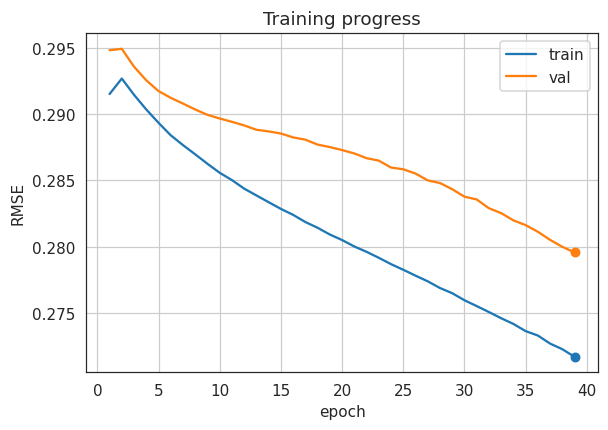

Epoch 1:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 001
TRAIN→ "R": RMSE=0.2915 MAE=0.2360 R2=-0.0128 | "B": Acc=0.3927 Prec=0.2735 Rec=0.7377 F1=0.3991 AUROC=0.5007
VALID→ "R": RMSE=0.2948 MAE=0.2052 R2=-0.0698 | "B": Acc=0.2812 Prec=0.2806 Rec=0.9995 F1=0.4381 AUROC=0.4989


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ "R": RMSE=0.2927 MAE=0.2222 R2=-0.0210 | "B": Acc=0.3837 Prec=0.2731 Rec=0.7545 F1=0.4010 AUROC=0.5007
VALID→ "R": RMSE=0.2949 MAE=0.2040 R2=-0.0706 | "B": Acc=0.2805 Prec=0.2804 Rec=0.9999 F1=0.4380 AUROC=0.4859


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ "R": RMSE=0.2915 MAE=0.2212 R2=-0.0124 | "B": Acc=0.3744 Prec=0.2729 Rec=0.7742 F1=0.4036 AUROC=0.5001
VALID→ "R": RMSE=0.2936 MAE=0.2031 R2=-0.0608 | "B": Acc=0.2804 Prec=0.2804 Rec=1.0000 F1=0.4380 AUROC=0.4694


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ "R": RMSE=0.2904 MAE=0.2205 R2=-0.0047 | "B": Acc=0.3629 Prec=0.2730 Rec=0.7997 F1=0.4070 AUROC=0.4993
VALID→ "R": RMSE=0.2926 MAE=0.2023 R2=-0.0534 | "B": Acc=0.2804 Prec=0.2804 Rec=1.0000 F1=0.4380 AUROC=0.4573


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ "R": RMSE=0.2893 MAE=0.2198 R2=0.0022 | "B": Acc=0.3548 Prec=0.2735 Rec=0.8209 F1=0.4103 AUROC=0.5005
VALID→ "R": RMSE=0.2917 MAE=0.2016 R2=-0.0476 | "B": Acc=0.2804 Prec=0.2804 Rec=1.0000 F1=0.4380 AUROC=0.4509


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ "R": RMSE=0.2884 MAE=0.2192 R2=0.0087 | "B": Acc=0.3486 Prec=0.2731 Rec=0.8321 F1=0.4113 AUROC=0.4998
VALID→ "R": RMSE=0.2912 MAE=0.2009 R2=-0.0439 | "B": Acc=0.2804 Prec=0.2804 Rec=1.0000 F1=0.4380 AUROC=0.4504


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ "R": RMSE=0.2877 MAE=0.2185 R2=0.0138 | "B": Acc=0.3473 Prec=0.2734 Rec=0.8367 F1=0.4121 AUROC=0.5005
VALID→ "R": RMSE=0.2908 MAE=0.2003 R2=-0.0408 | "B": Acc=0.2804 Prec=0.2804 Rec=1.0000 F1=0.4380 AUROC=0.4535


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ "R": RMSE=0.2870 MAE=0.2179 R2=0.0185 | "B": Acc=0.3464 Prec=0.2732 Rec=0.8379 F1=0.4121 AUROC=0.5005
VALID→ "R": RMSE=0.2904 MAE=0.1997 R2=-0.0376 | "B": Acc=0.2804 Prec=0.2804 Rec=1.0000 F1=0.4380 AUROC=0.4586


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ "R": RMSE=0.2863 MAE=0.2173 R2=0.0234 | "B": Acc=0.3459 Prec=0.2730 Rec=0.8375 F1=0.4118 AUROC=0.4999
VALID→ "R": RMSE=0.2900 MAE=0.1992 R2=-0.0347 | "B": Acc=0.2804 Prec=0.2804 Rec=1.0000 F1=0.4380 AUROC=0.4651


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ "R": RMSE=0.2856 MAE=0.2167 R2=0.0280 | "B": Acc=0.3463 Prec=0.2733 Rec=0.8382 F1=0.4121 AUROC=0.5003
VALID→ "R": RMSE=0.2897 MAE=0.1987 R2=-0.0328 | "B": Acc=0.2804 Prec=0.2804 Rec=1.0000 F1=0.4380 AUROC=0.4734


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ "R": RMSE=0.2850 MAE=0.2162 R2=0.0318 | "B": Acc=0.3464 Prec=0.2728 Rec=0.8348 F1=0.4112 AUROC=0.4996
VALID→ "R": RMSE=0.2894 MAE=0.1982 R2=-0.0310 | "B": Acc=0.2804 Prec=0.2804 Rec=1.0000 F1=0.4380 AUROC=0.4828


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ "R": RMSE=0.2844 MAE=0.2157 R2=0.0361 | "B": Acc=0.3469 Prec=0.2729 Rec=0.8346 F1=0.4113 AUROC=0.5006
VALID→ "R": RMSE=0.2892 MAE=0.1978 R2=-0.0291 | "B": Acc=0.2804 Prec=0.2804 Rec=1.0000 F1=0.4380 AUROC=0.4906


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ "R": RMSE=0.2839 MAE=0.2152 R2=0.0396 | "B": Acc=0.3502 Prec=0.2730 Rec=0.8281 F1=0.4107 AUROC=0.5004
VALID→ "R": RMSE=0.2888 MAE=0.1974 R2=-0.0267 | "B": Acc=0.2804 Prec=0.2804 Rec=1.0000 F1=0.4380 AUROC=0.4978


Epoch 14:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ "R": RMSE=0.2834 MAE=0.2148 R2=0.0431 | "B": Acc=0.3501 Prec=0.2726 Rec=0.8252 F1=0.4098 AUROC=0.4994
VALID→ "R": RMSE=0.2887 MAE=0.1971 R2=-0.0258 | "B": Acc=0.2805 Prec=0.2804 Rec=1.0000 F1=0.4380 AUROC=0.5102


Epoch 15:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ "R": RMSE=0.2829 MAE=0.2144 R2=0.0465 | "B": Acc=0.3507 Prec=0.2728 Rec=0.8252 F1=0.4100 AUROC=0.5002
VALID→ "R": RMSE=0.2885 MAE=0.1967 R2=-0.0247 | "B": Acc=0.2806 Prec=0.2805 Rec=1.0000 F1=0.4381 AUROC=0.5173


Epoch 16:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 016
TRAIN→ "R": RMSE=0.2824 MAE=0.2140 R2=0.0495 | "B": Acc=0.3525 Prec=0.2727 Rec=0.8208 F1=0.4094 AUROC=0.5010
VALID→ "R": RMSE=0.2882 MAE=0.1964 R2=-0.0226 | "B": Acc=0.2807 Prec=0.2805 Rec=0.9999 F1=0.4381 AUROC=0.5225


Epoch 17:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 017
TRAIN→ "R": RMSE=0.2819 MAE=0.2136 R2=0.0531 | "B": Acc=0.3566 Prec=0.2730 Rec=0.8141 F1=0.4089 AUROC=0.5013
VALID→ "R": RMSE=0.2881 MAE=0.1961 R2=-0.0214 | "B": Acc=0.2809 Prec=0.2805 Rec=0.9995 F1=0.4381 AUROC=0.5279


Epoch 18:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 018
TRAIN→ "R": RMSE=0.2814 MAE=0.2132 R2=0.0560 | "B": Acc=0.3562 Prec=0.2725 Rec=0.8114 F1=0.4080 AUROC=0.5006
VALID→ "R": RMSE=0.2877 MAE=0.1958 R2=-0.0188 | "B": Acc=0.2811 Prec=0.2804 Rec=0.9981 F1=0.4378 AUROC=0.5315


Epoch 19:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 019
TRAIN→ "R": RMSE=0.2809 MAE=0.2128 R2=0.0594 | "B": Acc=0.3600 Prec=0.2727 Rec=0.8047 F1=0.4074 AUROC=0.5010
VALID→ "R": RMSE=0.2875 MAE=0.1956 R2=-0.0175 | "B": Acc=0.2812 Prec=0.2802 Rec=0.9964 F1=0.4374 AUROC=0.5434


Epoch 20:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 020
TRAIN→ "R": RMSE=0.2805 MAE=0.2125 R2=0.0622 | "B": Acc=0.3604 Prec=0.2727 Rec=0.8035 F1=0.4072 AUROC=0.5015
VALID→ "R": RMSE=0.2873 MAE=0.1953 R2=-0.0159 | "B": Acc=0.2812 Prec=0.2792 Rec=0.9882 F1=0.4354 AUROC=0.5447


Epoch 21:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 021
TRAIN→ "R": RMSE=0.2800 MAE=0.2121 R2=0.0655 | "B": Acc=0.3643 Prec=0.2727 Rec=0.7948 F1=0.4060 AUROC=0.5018
VALID→ "R": RMSE=0.2870 MAE=0.1951 R2=-0.0141 | "B": Acc=0.2811 Prec=0.2774 Rec=0.9745 F1=0.4319 AUROC=0.5466


Epoch 22:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 022
TRAIN→ "R": RMSE=0.2796 MAE=0.2117 R2=0.0682 | "B": Acc=0.3685 Prec=0.2726 Rec=0.7849 F1=0.4046 AUROC=0.5013
VALID→ "R": RMSE=0.2867 MAE=0.1948 R2=-0.0115 | "B": Acc=0.2810 Prec=0.2755 Rec=0.9599 F1=0.4282 AUROC=0.5495


Epoch 23:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 023
TRAIN→ "R": RMSE=0.2792 MAE=0.2115 R2=0.0712 | "B": Acc=0.3713 Prec=0.2724 Rec=0.7777 F1=0.4035 AUROC=0.5019
VALID→ "R": RMSE=0.2865 MAE=0.1946 R2=-0.0102 | "B": Acc=0.2815 Prec=0.2737 Rec=0.9448 F1=0.4245 AUROC=0.5513


Epoch 24:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 024
TRAIN→ "R": RMSE=0.2787 MAE=0.2110 R2=0.0743 | "B": Acc=0.3752 Prec=0.2725 Rec=0.7698 F1=0.4025 AUROC=0.5020
VALID→ "R": RMSE=0.2860 MAE=0.1942 R2=-0.0066 | "B": Acc=0.2828 Prec=0.2719 Rec=0.9280 F1=0.4205 AUROC=0.5521


Epoch 25:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 025
TRAIN→ "R": RMSE=0.2783 MAE=0.2108 R2=0.0772 | "B": Acc=0.3786 Prec=0.2726 Rec=0.7626 F1=0.4016 AUROC=0.5023
VALID→ "R": RMSE=0.2858 MAE=0.1940 R2=-0.0056 | "B": Acc=0.2850 Prec=0.2699 Rec=0.9087 F1=0.4161 AUROC=0.5509


Epoch 26:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 026
TRAIN→ "R": RMSE=0.2778 MAE=0.2104 R2=0.0801 | "B": Acc=0.3831 Prec=0.2728 Rec=0.7542 F1=0.4007 AUROC=0.5033
VALID→ "R": RMSE=0.2855 MAE=0.1938 R2=-0.0034 | "B": Acc=0.2869 Prec=0.2694 Rec=0.9015 F1=0.4148 AUROC=0.5569


Epoch 27:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 027
TRAIN→ "R": RMSE=0.2774 MAE=0.2101 R2=0.0829 | "B": Acc=0.3843 Prec=0.2731 Rec=0.7536 F1=0.4009 AUROC=0.5044
VALID→ "R": RMSE=0.2850 MAE=0.1935 R2=0.0002 | "B": Acc=0.2910 Prec=0.2679 Rec=0.8823 F1=0.4111 AUROC=0.5559


Epoch 28:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 028
TRAIN→ "R": RMSE=0.2769 MAE=0.2098 R2=0.0863 | "B": Acc=0.3886 Prec=0.2728 Rec=0.7425 F1=0.3991 AUROC=0.5038
VALID→ "R": RMSE=0.2848 MAE=0.1933 R2=0.0016 | "B": Acc=0.2957 Prec=0.2666 Rec=0.8635 F1=0.4074 AUROC=0.5548


Epoch 29:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 029
TRAIN→ "R": RMSE=0.2765 MAE=0.2094 R2=0.0888 | "B": Acc=0.3920 Prec=0.2730 Rec=0.7360 F1=0.3983 AUROC=0.5048
VALID→ "R": RMSE=0.2843 MAE=0.1930 R2=0.0049 | "B": Acc=0.3021 Prec=0.2658 Rec=0.8450 F1=0.4044 AUROC=0.5544


Epoch 30:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 030
TRAIN→ "R": RMSE=0.2760 MAE=0.2091 R2=0.0923 | "B": Acc=0.3951 Prec=0.2730 Rec=0.7293 F1=0.3973 AUROC=0.5051
VALID→ "R": RMSE=0.2838 MAE=0.1927 R2=0.0089 | "B": Acc=0.3125 Prec=0.2654 Rec=0.8213 F1=0.4012 AUROC=0.5526


Epoch 31:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 031
TRAIN→ "R": RMSE=0.2755 MAE=0.2088 R2=0.0952 | "B": Acc=0.3998 Prec=0.2735 Rec=0.7215 F1=0.3966 AUROC=0.5060
VALID→ "R": RMSE=0.2836 MAE=0.1924 R2=0.0103 | "B": Acc=0.3275 Prec=0.2661 Rec=0.7953 F1=0.3988 AUROC=0.5512


Epoch 32:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 032
TRAIN→ "R": RMSE=0.2751 MAE=0.2084 R2=0.0982 | "B": Acc=0.4028 Prec=0.2735 Rec=0.7149 F1=0.3956 AUROC=0.5059
VALID→ "R": RMSE=0.2829 MAE=0.1921 R2=0.0149 | "B": Acc=0.3411 Prec=0.2678 Rec=0.7780 F1=0.3984 AUROC=0.5527


Epoch 33:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 033
TRAIN→ "R": RMSE=0.2746 MAE=0.2081 R2=0.1012 | "B": Acc=0.4057 Prec=0.2742 Rec=0.7125 F1=0.3960 AUROC=0.5082
VALID→ "R": RMSE=0.2825 MAE=0.1918 R2=0.0175 | "B": Acc=0.3614 Prec=0.2714 Rec=0.7581 F1=0.3997 AUROC=0.5555


Epoch 34:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 034
TRAIN→ "R": RMSE=0.2742 MAE=0.2078 R2=0.1041 | "B": Acc=0.4077 Prec=0.2743 Rec=0.7090 F1=0.3956 AUROC=0.5086
VALID→ "R": RMSE=0.2820 MAE=0.1915 R2=0.0213 | "B": Acc=0.3771 Prec=0.2750 Rec=0.7462 F1=0.4019 AUROC=0.5594


Epoch 35:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 035
TRAIN→ "R": RMSE=0.2736 MAE=0.2075 R2=0.1076 | "B": Acc=0.4088 Prec=0.2748 Rec=0.7093 F1=0.3961 AUROC=0.5105
VALID→ "R": RMSE=0.2816 MAE=0.1912 R2=0.0238 | "B": Acc=0.4025 Prec=0.2796 Rec=0.7171 F1=0.4023 AUROC=0.5591


Epoch 36:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 036
TRAIN→ "R": RMSE=0.2733 MAE=0.2071 R2=0.1098 | "B": Acc=0.4099 Prec=0.2744 Rec=0.7047 F1=0.3950 AUROC=0.5095
VALID→ "R": RMSE=0.2811 MAE=0.1909 R2=0.0272 | "B": Acc=0.4204 Prec=0.2841 Rec=0.7020 F1=0.4045 AUROC=0.5612


Epoch 37:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 037
TRAIN→ "R": RMSE=0.2727 MAE=0.2068 R2=0.1137 | "B": Acc=0.4135 Prec=0.2755 Rec=0.7028 F1=0.3958 AUROC=0.5122
VALID→ "R": RMSE=0.2805 MAE=0.1905 R2=0.0315 | "B": Acc=0.4556 Prec=0.2903 Rec=0.6518 F1=0.4017 AUROC=0.5560


Epoch 38:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 038
TRAIN→ "R": RMSE=0.2723 MAE=0.2064 R2=0.1165 | "B": Acc=0.4183 Prec=0.2757 Rec=0.6931 F1=0.3945 AUROC=0.5118
VALID→ "R": RMSE=0.2800 MAE=0.1902 R2=0.0351 | "B": Acc=0.4743 Prec=0.2963 Rec=0.6364 F1=0.4043 AUROC=0.5592


Epoch 39:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 039
TRAIN→ "R": RMSE=0.2717 MAE=0.2061 R2=0.1202 | "B": Acc=0.4199 Prec=0.2765 Rec=0.6937 F1=0.3954 AUROC=0.5144
VALID→ "R": RMSE=0.2796 MAE=0.1899 R2=0.0380 | "B": Acc=0.5063 Prec=0.3045 Rec=0.5923 F1=0.4022 AUROC=0.5555


Epoch 40:   0%|          | 0/60 [00:00<?, ?batch/s]

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
#  Create Optuna study and run optimization
# ──────────────────────────────────────────────────────────────────────────────

study = optuna.create_study(
    storage="sqlite:///optuna_study.db",    # Point it at an SQLite file so it writes out each result immediately instead of buffering in RAM
    load_if_exists=True,
    direction="minimize",
    pruner=MedianPruner(n_startup_trials=6, n_warmup_steps=12),
)

        
study.optimize(
    objective,
    n_trials = 100,
    n_jobs   = 1,
    callbacks=[live_cb, plots.cleanup_callback],
)

plt.close('all')   # safe here; the final image remains displayed in the notebook output
gc.collect()       # optional extra sweep



In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
#  Print out the best hyperparameters & result
# ──────────────────────────────────────────────────────────────────────────────
print("Best hyperparameters:", study.best_params)
print("Best validation RMSE:", study.best_value)

# ──────────────────────────────────────────────────────────────────────────────
#  Compute and print parameter importances
# ──────────────────────────────────────────────────────────────────────────────
imps = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact on RMSE):")
for name, score in sorted(imps.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s} : {score:.3f}")

# ──────────────────────────────────────────────────────────────────────────────
#  Dump study results to JSON
# ──────────────────────────────────────────────────────────────────────────────
# 1) Build your session‐only DataFrame once
session_df = df.between_time(params.regular_start,
                             params.regular_end)

# 2) Derive the trading‐day boundaries
first_day = session_df.index.normalize().min()
last_day  = session_df.index.normalize().max()

# 3) Format your file name
start_date = first_day.strftime("%Y%m%d")
end_date   = last_day.strftime("%Y%m%d")
file_name  = f"{params.ticker}_{start_date}-{end_date}_optuna_model_hpars.json"
file_path  = os.path.join(results_folder, file_name)


# ------------------------------------------------------------------
# Dump study results (including importances)
# ------------------------------------------------------------------

with open(file_path, "w") as f:
    json.dump(
        {
            "best_params": study.best_params,
            "best_value" : study.best_value,
            "importances": imps,
            "trials": [
                {"number": t.number, "value": t.value, "params": t.params, 
                 "state": t.state.name}
                for t in study.trials
            ],
        },
        f,
        indent=4,
    )

print(f"\nOptuna results (and importances) saved to: {file_path}")
